# $\mathcal{Option~sur~spread~-~Romanet~x~Ahamada}$

In [39]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy.linalg as ln
from scipy.stats import norm

### $\bullet\quad \mathcal{Densité\ d'une\ variable\ gaussienne\ quelconque\ N(esp,var)}$

In [40]:
def f(x, esp, var):
    return np.exp(-((x-esp)**2)/(2*var))/np.sqrt(2*np.pi*var)

### $\bullet\quad \mathcal{Fonction\ de\ répartition\ (approximative)\ d'une\ variable\ gaussienne\ centrée\ réduite}$ 

In [41]:
def psi(x):
    b0 = 0.2316419
    b1 = 0.319381530
    b2 = -0.356563782
    b3 = 1.781477937
    b4 = -1.821255978
    b5 = 1.330274429
    if x >= 0:
        t = 1/(1+b0*x)
        return 1 - np.exp(-(x**2)/2)*(b1*t + b2*t**2 + b3*t**3 + b4*t**4 + b5*t**5) / np.sqrt(2*np.pi)
    else:
        t = 1/(1+b0*(-x))
        return np.exp(-(x**2)/2)*(b1*t + b2*t**2 + b3*t**3 + b4*t**4 + b5*t**5) / np.sqrt(2*np.pi)
    
vpsi = np.vectorize(psi)

### $\bullet\quad \mathcal{Prix~de~l'option~de~vente~européenne}$

In [42]:
def put(r, S0, sigma, T, K, N, W = [], vec = False):
    # Prix par Monte-Carlo - Semi Box-Muller
    if np.size(W) == 0:
        W = np.sqrt(T)*np.sqrt(-2*np.log(rand.random(N)))*np.cos(2*np.pi*rand.random(N))
    S = S0*np.exp((r - 0.5*sigma**2)*T + sigma*W)
    payoff = np.exp(-r*T)*np.maximum(K-S,0)
    P = np.mean(payoff)
    
    # Payoff
    if vec:
        return payoff
    
    # Prix explicite
    d1 = (np.log(K/S0) - (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    Pe = K*np.exp(-r*T)*psi(d1) - S0*psi(d2)
    
    return P, Pe

# $\mathcal{Question~3}$

### $\bullet\quad \mathcal{Données}$ 

In [43]:
sigma1, sigma2 = 0.25, 0.3
S10, S20 = 1, 1
alpha, beta = 1, 1
rho = 0.5
r = 0.01
T = 2
hatsigma = np.sqrt(sigma1**2 + sigma2**2 - 2*sigma1*sigma2*rho)

### $\bullet\quad \mathcal{Simulation\ de\ W(T)}$ 

Pour simuler les variables aléatoires $W_1(T)$ et $W_3(T)$, nous appliquerons la méthode de Box-Muller. Afin de simuler le vecteur $W(T) = (W_1(T), W_2(T))$, nous allons prendre en compte la corrélation existante entre les deux mouvements browniens $W_1(T)$ et $W_2(T)$. Pour ce faire, nous allons utiliser une méthode de Cholesky, ce qui donne : $$W_2 = \rho W_1+\sqrt{1-\rho^2}W_3$$

In [44]:
###############################
#          Fonctions          #
###############################

def couple_independant(T, n = 1):
    # Génération de deux variables uniformes sur (0,1)
    U = rand.random(n)
    V = rand.random(n)
    # Calcul des variables aléatoires normales centrées réduites indépendantes
    X = np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)
    Y = np.sqrt(-2*np.log(U))*np.sin(2*np.pi*V)
    # Transformation linéaire pour obtenir des variables de variance T
    W1 = np.sqrt(T)*X
    W3 = np.sqrt(T)*Y
    return W1, W3

def couple_correle(T, n = 1):
    Z = couple_independant(T, n)
    W = (Z[0], rho*Z[0] + np.sqrt(1-rho**2)*Z[1])
    return W

# Bonus S = (S1, S2)
def cours_actifs(T, n = 1):
    t = T*np.ones(n)
    W = couple_correle(T, n)
    S = np.array([S10*np.exp((r - 0.5*sigma1**2)*t + sigma1*W[0]), S20*np.exp((r - 0.5*sigma2**2)*t + sigma2*W[1])])
    return S

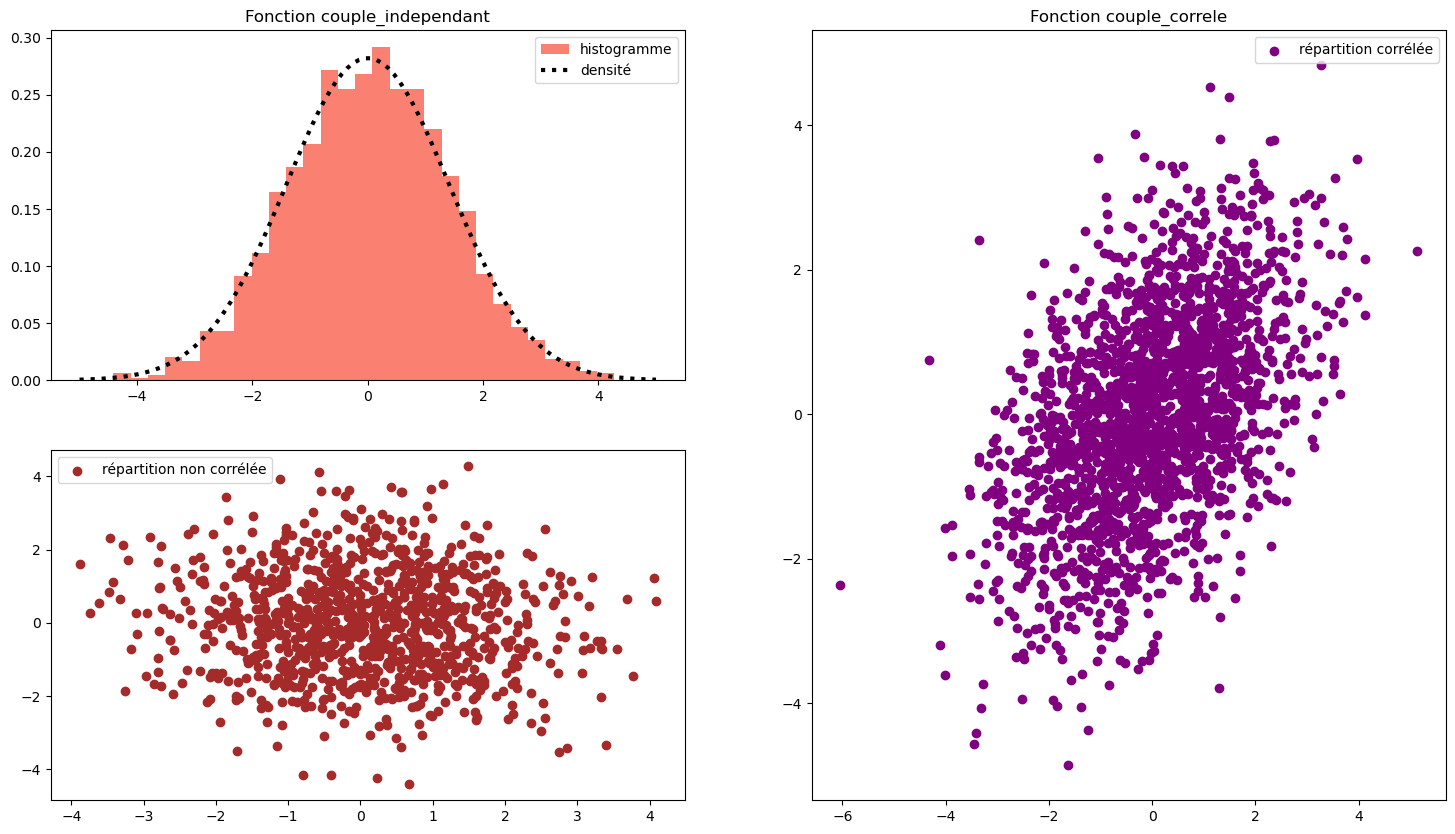

In [45]:
###############################
#         Vérification        #
###############################

nZ = 1000
nW = 2000
Z = couple_independant(T,nZ)
Z1 = Z[0]
Z2 = Z[1]
Zc = np.concatenate((Z1, Z2), axis = 0)
W = couple_correle(T,nW)
x = np.linspace(-5,5,100)
# Graphique
fig = plt.figure(figsize=(18,10))
grid = plt.GridSpec(2, 2)
# Caractère gaussien
ax1 = fig.add_subplot(grid[0, 0])
ax1.set_title('Fonction couple_independant')
ax1.hist(Zc, bins = 'auto', density = 'True', color = 'salmon', label = 'histogramme')
ax1.plot(x, f(x,0,T), linestyle = ':', color = 'k', linewidth = 3, label = 'densité')
ax1.legend()
# Indépendance
ax2 = fig.add_subplot(grid[1, 0])
ax2.scatter(Z1, Z2, color = 'brown', label = 'répartition non corrélée')
ax2.legend()
# Corrélation
ax3 = fig.add_subplot(grid[:, 1])
ax3.set_title('Fonction couple_correle')
ax3.scatter(W[0], W[1], color = 'purple', label = 'répartition corrélée')
ax3.legend()
# Affichage
plt.show()

$\star\quad$ L'histogramme des échantillons présente une forme en cloche, suggérant que leur distribution suit une loi normale. Le nuage de points obtenu à partir du graphe de corrélation ne montre pas de structure évidente et la répartition uniforme des points dans le plan reflète l'absence de corrélation entre les échantillons.

$\star\quad$ Lorsque $\rho=0.5$ (comme dans notre cas), les deux actifs ont une corrélation positive modérée, indiquant qu'ils ont tendance à évoluer dans la même direction, mais pas de manière systématique. Ils peuvent également avoir des mouvements opposés de temps en temps.

$\Longrightarrow\quad$ Nous pouvons conclure que notre programme est correct pour la génération d'échantillons indépendants et corrélés de variables aléatoires gaussiennes.

### $\bullet\quad \mathcal{Calcul\ de\ P\ par\ MC\ classique}$ 

In [46]:
Prix = put(0, beta*S20, hatsigma, T, alpha*S10, 90000)
print('Prix MC class. : ', Prix[0])
print('Prix explicite : ', Prix[1])

Prix MC class. :  0.15675996486879673
Prix explicite :  0.1560551932275573


Les deux résultats semblent similaires, ce qui suggère que la méthode de Monte Carlo a été implémentée correctement. Toutefois, pour une vérification plus rigoureuse, nous examinerons cela dans la question 5 en vérifiant si l'intervalle de confiance calculé par la méthode de Monte Carlo classique est cohérent avec le nombre d'itérations utilisé. En effet, plus le nombre d'itérations est élevé, plus l'intervalle de confiance devrait être petit.

# $\mathcal{Question~4}$

Pour accroître la précision de notre estimation et réduire l'intervalle de confiance, nous pouvons appliquer une méthode de Monte Carlo avec une réduction de variance. Vous pourrez trouver les calculs détaillés dans le rapport.

### $\bullet\quad \mathcal{Technique\ basée\ sur\ le\ conditionnement}$ 

In [47]:
def cond(sigma1, sigma2, S10, S20, alpha, beta, rho, r, T, N, W1 = [], vec = False):
    # Prix par Monte-Carlo - Semi Box-Muller
    if np.size(W1) == 0:
        W1 = np.sqrt(T)*np.sqrt(-2*np.log(rand.random(N)))*np.cos(2*np.pi*rand.random(N))
    # Variables
    S0c = beta*S20*np.exp(rho*sigma2*W1 - 0.5*T*(rho*sigma2)**2)
    sigmac = sigma2*np.sqrt(1-rho**2)
    Kc = alpha*S10*np.exp(sigma1*W1 + (r - 0.5*sigma1**2)*T)
    d1c = (np.log(Kc/S0c) - (r - 0.5*sigmac**2)*T) / (sigmac*np.sqrt(T))
    d2c = d1c - sigmac*np.sqrt(T)
    # Prix
    phi = Kc*np.exp(-r*T)*vpsi(d1c) - S0c*vpsi(d2c)
    P = np.mean(phi)
    
    # Payoff
    if vec:
        return phi
 
    return P

### $\bullet\quad \mathcal{Technique\ de\ variables\ antithétiques}$ 

In [48]:
 def anti(sigma1, sigma2, S10, S20, alpha, beta, rho, r, T, N, Wp = [], Wm = [], vec = False):
    if np.size(Wp) == 0 or np.size(Wm) == 0:
        Z = couple_independant(T, N)
        # Mouvements browniens corrélés 
        Wp = ( Z[0],  rho*Z[0] + np.sqrt(1-rho**2)*Z[1])  
        Wm = (-Z[0], -rho*Z[0] - np.sqrt(1-rho**2)*Z[1])
    # Vecteurs des sous-jacents
    t = T*np.ones(N)
    Sp = np.array([S10*np.exp((r-0.5*sigma1**2)*t + sigma1*Wp[0]), S20*np.exp((r-0.5*sigma2**2)*t + sigma2*Wp[1])])
    Sm = np.array([S10*np.exp((r-0.5*sigma1**2)*t + sigma1*Wm[0]), S20*np.exp((r-0.5*sigma2**2)*t + sigma2*Wm[1])])
    # Options d'échange
    diffp = np.maximum(alpha*Sp[0,:] - beta*Sp[1,:], 0)
    diffm = np.maximum(alpha*Sm[0,:] - beta*Sm[1,:], 0)
    diff = np.exp(-r*T)*(diffp + diffm) / 2
    
    # Payoff
    if vec:
        return diff
    
    # Prix de l'option 
    return np.mean(diff)

### $\bullet\quad \mathcal{Comparaison}$ 

In [49]:
Prixc = cond(sigma1, sigma2, S10, S20, alpha, beta, rho, r, T, 90000)
Prixa = anti(sigma1, sigma2, S10, S20, alpha, beta, rho, r, T, 90000)
print('Prix MC condi. : ', Prixc)
print('Prix MC antit. : ', Prixa)
print('Prix explicite : ', Prix[1])

Prix MC condi. :  0.15639728880864945
Prix MC antit. :  0.15609892106512294
Prix explicite :  0.1560551932275573


Les résultats semblent similaires, ce qui suggère que les nouvelles méthodes ont été correctement implémentées. Pour confirmer cette hypothèse, on peut faire de même que pour la méthode classique. Par ailleurs, il est conseillé de tester le programme avec différentes valeurs de paramètres afin de s'assurer de sa robustesse et de sa capacité à fonctionner correctement pour une variété de scénarios. Dans notre cas, nous ferons varier uniquement le paramètre $\rho$ dans la question suivante.

# $\mathcal{Question~5}$

Nous allons maintenant procéder à une comparaison plus rigoureuse des résultats en traçant les prix calculés avec les méthodes de Monte Carlo ainsi que leur intervalle de confiance associé en fonction du nombre de trajectoires sur un même graphique. Cette visualisation nous permettra d'avoir une idée claire de l'exactitude de nos résultats.

In [50]:
def intervalle_confiance_90(X):
    moy = np.mean(X)
    erreur = 1.64 * np.std(X) / np.sqrt(np.size(X))
    return moy, moy - erreur, moy + erreur, erreur

### $\bullet\quad \mathcal{Technique\ basée\ sur\ le\ conditionnement}$ 

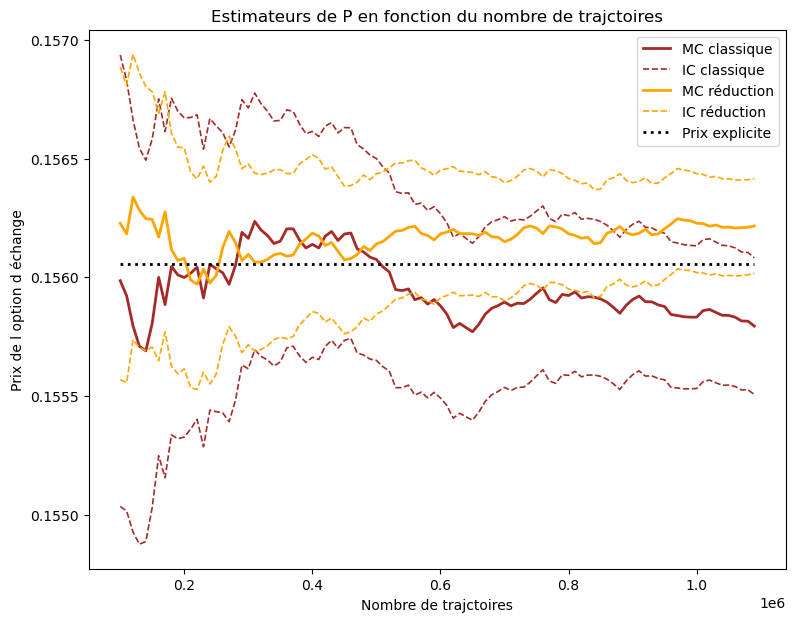

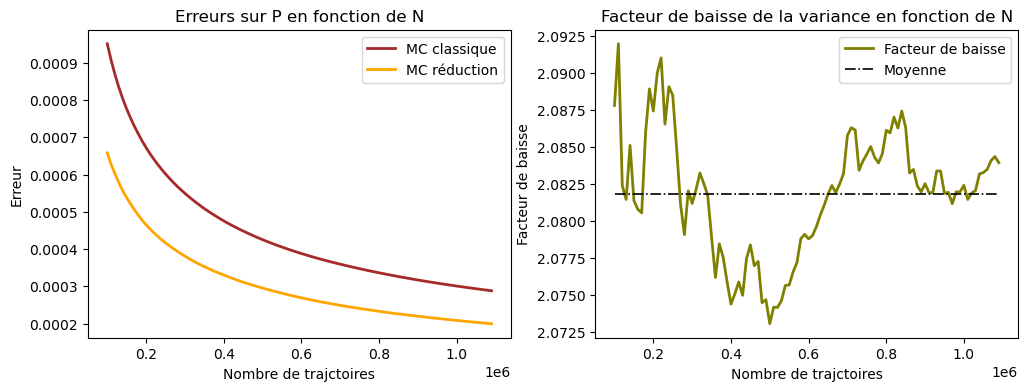

Facteur de baisse :  2.0818303662845317


In [53]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 100000
delta_n = 10000
nb = 100
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs1 = np.zeros((nb,4))
erreurs2 = np.zeros((nb,4))

###########################################################
#         Initialisation des variables aléatoires         #
###########################################################

W = np.sqrt(T)*np.sqrt(-2*np.log(rand.random(fin-1)))*np.cos(2*np.pi*rand.random(fin-1))
P1 = put(0, beta*S20, hatsigma, T, alpha*S10, fin-1, W, True)
P2 = cond(sigma1, sigma2, S10, S20, alpha, beta, rho, r, T, fin-1, W, True)

###########################################################
#                  Boucle de remplissage                  #
###########################################################

for j in range(nb):
    erreurs1[j] = intervalle_confiance_90(P1[0:x0[j+1]])
    erreurs2[j] = intervalle_confiance_90(P2[0:x0[j+1]])

###########################################################
#                Graphique des estimateurs                #
###########################################################

plt.figure(figsize = (9, 7))
plt.title('Estimateurs de P en fonction du nombre de trajctoires')
# MC classique
plt.plot(x, erreurs1[:,0], color = 'brown', linewidth = 2, label = 'MC classique')
plt.plot(x, erreurs1[:,1], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC classique')
plt.plot(x, erreurs1[:,2], color = 'brown', linewidth = 1.2, linestyle = '--')
# MC réduction
plt.plot(x, erreurs2[:,0], color = 'orange', linewidth = 2, label = 'MC réduction')
plt.plot(x, erreurs2[:,1], color = 'orange', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
plt.plot(x, erreurs2[:,2], color = 'orange', linewidth = 1.2, linestyle = '--')
# Prix explicite
plt.plot(x, np.ones(np.size(x))*Prix[1], color = 'black', 
         linewidth = 2, linestyle = ':', label = 'Prix explicite')
# Légende
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Prix de l option d échange')
plt.legend()
plt.show()

###########################################################
#                  Graphique des erreurs                  #
###########################################################

fig = plt.figure(figsize = (12, 4))
grid = plt.GridSpec(2, 2)

ax1 = fig.add_subplot(grid[:, 0])
ax1.set_title('Erreurs sur P en fonction de N')
# MC classique
ax1.plot(x, erreurs1[:,3], color = 'brown', linewidth = 2, label = 'MC classique')
# MC réduction
ax1.plot(x, erreurs2[:,3], color = 'orange', linewidth = 2, label = 'MC réduction')
# Légende
ax1.set_xlabel('Nombre de trajctoires')
ax1.set_ylabel('Erreur')
ax1.legend()

ax2 = fig.add_subplot(grid[:, 1])
ax2.set_title('Facteur de baisse de la variance en fonction de N')
Baisse = (erreurs1[:,3]/erreurs2[:,3])**2
ecart = np.mean(Baisse)
ax2.plot(x, Baisse, color = 'olive', linewidth = 2, label = 'Facteur de baisse')
ax2.plot(x, np.ones(nb)*np.mean(Baisse), color = 'k', linewidth = 1.2, linestyle = '-.', label = 'Moyenne')
ax2.set_xlabel('Nombre de trajctoires')
ax2.set_ylabel('Facteur de baisse')
ax2.legend()

plt.show()

# Réduction de la variance ? 
print('Facteur de baisse : ', ecart)

### $\bullet\quad \mathcal{Technique\ de\ variables\ antithétiques}$ 

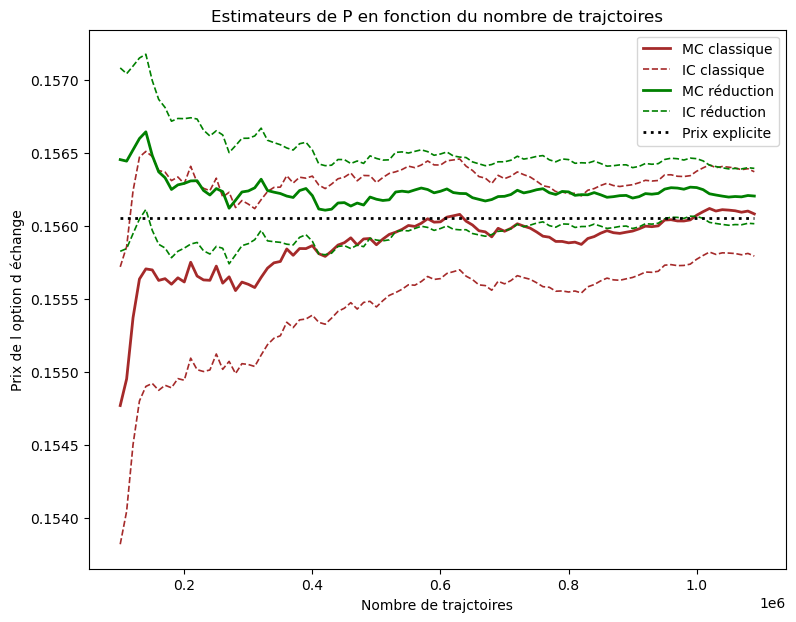

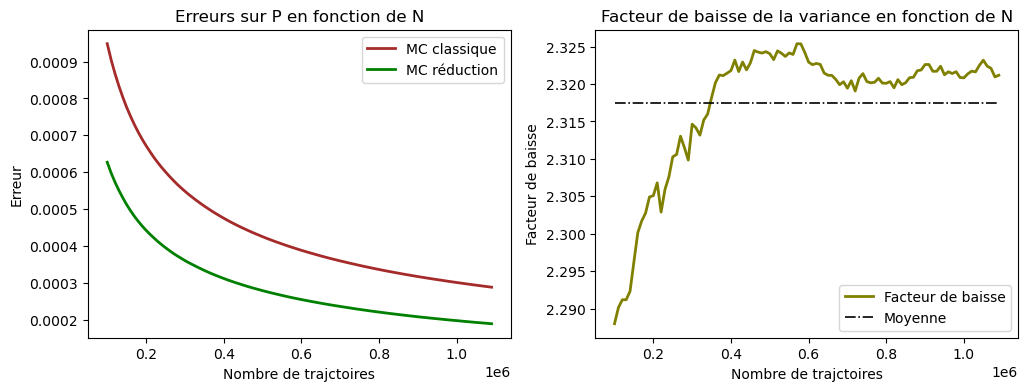

Facteur de baisse :  2.3175067062965766


In [55]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 100000
delta_n = 10000
nb = 100
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs1 = np.zeros((nb,4))
erreurs2 = np.zeros((nb,4))

###########################################################
#         Initialisation des variables aléatoires         #
###########################################################

W1, W3 = couple_independant(T, fin-1)
Wp = ( W1,  rho*W1 + np.sqrt(1-rho**2)*W3)  
Wm = (-W1, -rho*W1 - np.sqrt(1-rho**2)*W3)

P1 = put(0, beta*S20, hatsigma, T, alpha*S10, fin-1, W1, True)
P2 = anti(sigma1, sigma2, S10, S20, alpha, beta, rho, r, T, fin-1, Wp, Wm, True)

###########################################################
#                  Boucle de remplissage                  #
###########################################################

for j in range(nb):
    erreurs1[j] = intervalle_confiance_90(P1[0:x0[j+1]])
    erreurs2[j] = intervalle_confiance_90(P2[0:x0[j+1]])

###########################################################
#                Graphique des estimateurs                #
###########################################################

plt.figure(figsize = (9, 7))
plt.title('Estimateurs de P en fonction du nombre de trajctoires')
# MC classique
plt.plot(x, erreurs1[:,0], color = 'brown', linewidth = 2, label = 'MC classique')
plt.plot(x, erreurs1[:,1], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC classique')
plt.plot(x, erreurs1[:,2], color = 'brown', linewidth = 1.2, linestyle = '--')
# MC réduction
plt.plot(x, erreurs2[:,0], color = 'green', linewidth = 2, label = 'MC réduction')
plt.plot(x, erreurs2[:,1], color = 'green', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
plt.plot(x, erreurs2[:,2], color = 'green', linewidth = 1.2, linestyle = '--')
# Prix explicite
plt.plot(x, np.ones(np.size(x))*Prix[1], color = 'black', 
         linewidth = 2, linestyle = ':', label = 'Prix explicite')
# Légende
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Prix de l option d échange')
plt.legend()
plt.show()

###########################################################
#                  Graphique des erreurs                  #
###########################################################

fig = plt.figure(figsize = (12, 4))
grid = plt.GridSpec(2, 2)

ax1 = fig.add_subplot(grid[:, 0])
ax1.set_title('Erreurs sur P en fonction de N')
# MC classique
ax1.plot(x, erreurs1[:,3], color = 'brown', linewidth = 2, label = 'MC classique')
# MC réduction
ax1.plot(x, erreurs2[:,3], color = 'green', linewidth = 2, label = 'MC réduction')
# Légende
ax1.set_xlabel('Nombre de trajctoires')
ax1.set_ylabel('Erreur')
ax1.legend()

ax2 = fig.add_subplot(grid[:, 1])
ax2.set_title('Facteur de baisse de la variance en fonction de N')
Baisse = (erreurs1[:,3]/erreurs2[:,3])**2
ecart = np.mean(Baisse)
ax2.plot(x, Baisse, color = 'olive', linewidth = 2, label = 'Facteur de baisse')
ax2.plot(x, np.ones(nb)*np.mean(Baisse), color = 'k', linewidth = 1.2, linestyle = '-.', label = 'Moyenne')
ax2.set_xlabel('Nombre de trajctoires')
ax2.set_ylabel('Facteur de baisse')
ax2.legend()

plt.show()

# Réduction de la variance ? 
print('Facteur de baisse : ', ecart)

### $\bullet\quad \mathcal{Commentaires}$ 

Les résultats obtenus par les méthodes de Monte-Carlo classique et de réduction de variance ont été comparés et ont montré que les deux méthodes permettent d'obtenir une estimation du prix de l'option d'échange qui se rapproche du prix explicite, tout en réduisant l'intervalle de confiance associé à chaque estimation à mesure que le nombre de trajectoires augmente.

Cependant, la méthode de réduction de variance semble être plus efficace que la méthode classique, car elle réduit davantage la variance associée à l'estimation du prix. Ainsi, la méthode de réduction de variance peut être préférée pour des problèmes financiers plus complexes ou pour des instruments financiers dont le prix est plus difficile à estimer.

Dans notre cas, avec les constantes initiales, la méthode de réduction de variance par variables antithétiques est probablement plus efficace que celle par conditionnement.

# $\mathcal{Question~6}$

Pour choisir un nombre de trajectoires pour lequel l'estimation avec réduction de variance est assez précise, on peut fixer un critère tel que la largeur de l'intervalle de confiance soit inférieure à un certain seuil $\varepsilon$. Par exemple, on peut choisir $\varepsilon = 2\times10^{-3}$ pour avoir une précision à trois décimales près.

### $\bullet\quad \mathcal{Technique\ basée\ sur\ le\ conditionnement}$ 

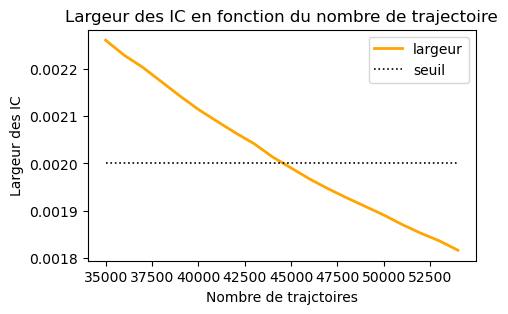

In [56]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 35000
delta_n = 1000
nb = 20
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs = np.zeros((nb,4))

###########################################################
#            Variable aléatoire et remplissage            #
###########################################################

P = cond(sigma1, sigma2, S10, S20, alpha, beta, rho, r, T, fin-1, [],  True)

for j in range(nb):
    erreurs[j] = intervalle_confiance_90(P[0:x0[j+1]]) 
    
largeurs = 2*erreurs[:,3]

###########################################################
#                        Graphique                        #
###########################################################

plt.figure(figsize = (5, 3))
plt.title('Largeur des IC en fonction du nombre de trajectoire')
plt.plot(x, largeurs, color = 'orange', linewidth = 2, label = 'largeur')
plt.plot(x, 0.002*np.ones(np.size(x)), color = 'k', linewidth = 1.2, linestyle = ':', label = 'seuil')
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Largeur des IC')
plt.legend()
plt.show()

En modélisant $55000$ trajectoires avec une réduction de variance, on obtient des intervalles de confiance assez précis à partir de $N=45000$ trajectoires. En effet, à partir de ce nombre, l'intervalle de confiance reste sous la barre des $2\times10^{-3}$.

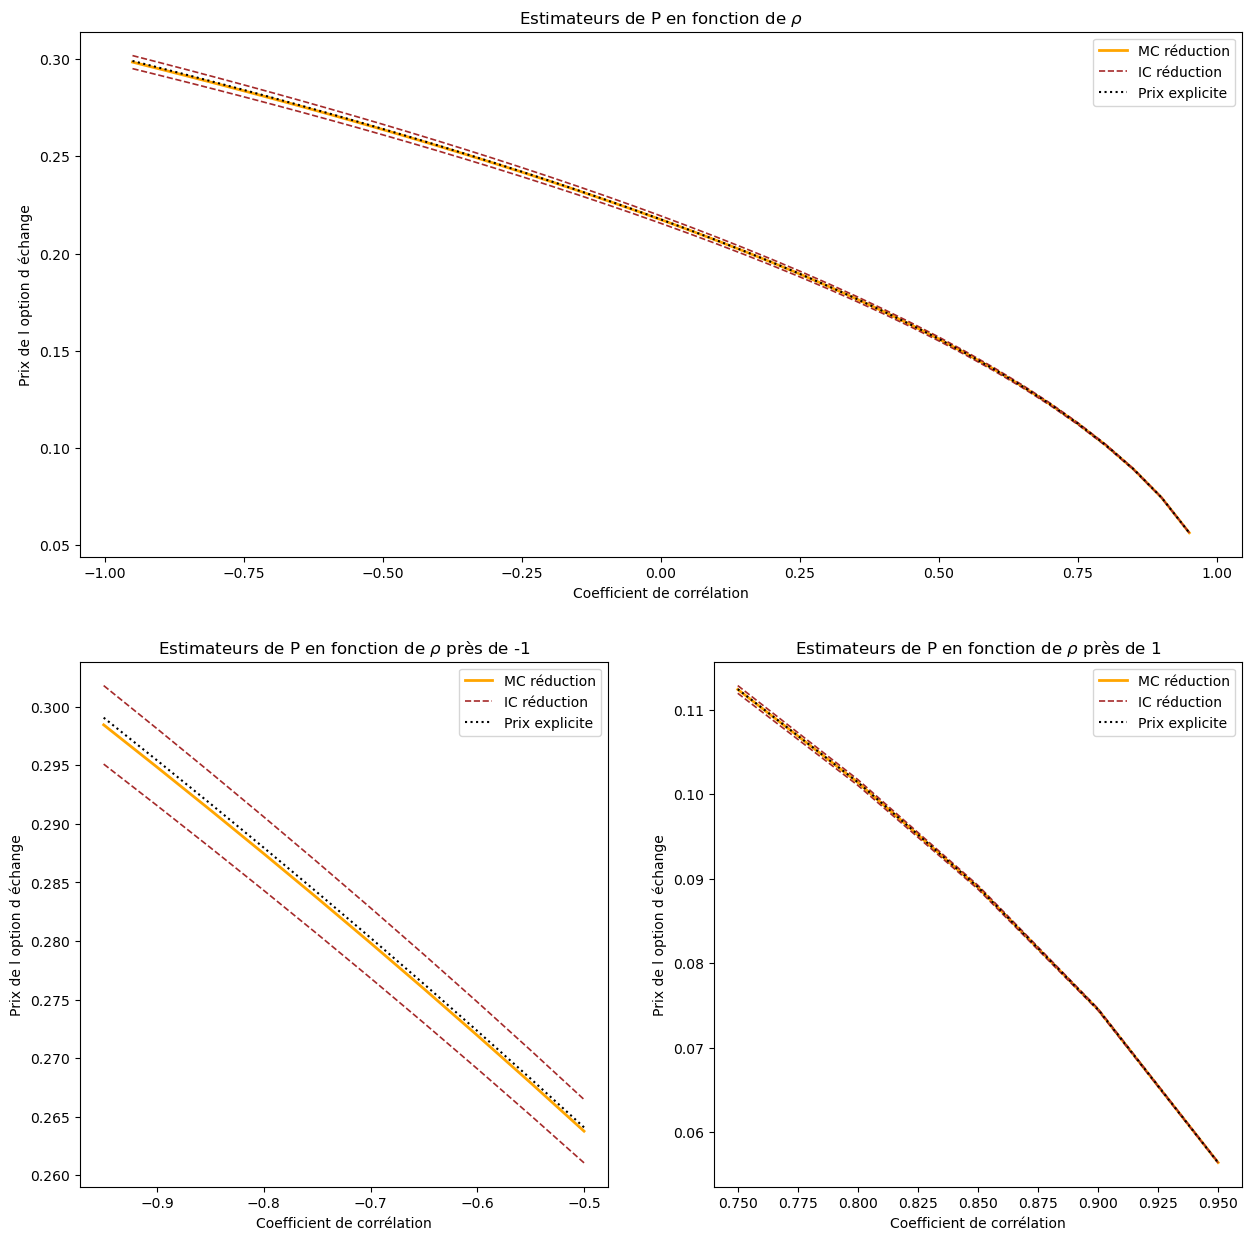

In [58]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

# Nombre de trajectoires pour une estimation assez précise
N = 45000

dn = 0.05
Vrho = np.arange(-1+dn, 1, dn)
s = np.size(Vrho)
erreurs = np.zeros((s,4))
Vexpl = np.zeros(s)

###########################################################
#            Variable aléatoire et remplissage            #
###########################################################

W = np.sqrt(T)*np.sqrt(-2*np.log(rand.random(N)))*np.cos(2*np.pi*rand.random(N))

# Boucle de remplissage
for k in range(s):
    # Prix avec réduction de variance
    P = cond(sigma1, sigma2, S10, S20, alpha, beta, Vrho[k], r, T, N, W,  True)
    erreurs[k] = intervalle_confiance_90(P)
    # Prix explicite
    hatsigma2 = sigma1**2 + sigma2**2 - 2*sigma1*sigma2*Vrho[k]
    d1 = (np.log((alpha*S10)/(beta*S20)) + (hatsigma2*T/2)) / np.sqrt(hatsigma2*T)
    d2 = d1 - np.sqrt(hatsigma2*T)
    Vexpl[k] = alpha*S10*psi(d1) - beta*S20*psi(d2)
    
###########################################################
#                        Graphique                        #
###########################################################

fig = plt.figure(figsize = (15, 15))
grid = plt.GridSpec(2, 2)

moy = erreurs[:,0]
ICg = erreurs[:,1]
ICd = erreurs[:,2]

# Global
ax1 = fig.add_subplot(grid[0, :])
ax1.set_title(r'Estimateurs de P en fonction de $\rho$')
# MC réduction
ax1.plot(Vrho, moy, color = 'orange', linewidth = 2, label = 'MC réduction')
ax1.plot(Vrho, ICg, color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
ax1.plot(Vrho, ICd, color = 'brown', linewidth = 1.2, linestyle = '--')
# Prix explicite
ax1.plot(Vrho, Vexpl, color = 'black', 
         linewidth = 1.5, linestyle = ':', label = 'Prix explicite')
# Légende
ax1.set_xlabel('Coefficient de corrélation')
ax1.set_ylabel('Prix de l option d échange')
ax1.legend()

# Zoom à gauche
ax2 = fig.add_subplot(grid[1, 0])
ax2.set_title(r'Estimateurs de P en fonction de $\rho$ près de -1')
# MC réduction
ax2.plot(Vrho[0:10], moy[0:10], color = 'orange', linewidth = 2, label = 'MC réduction')
ax2.plot(Vrho[0:10], ICg[0:10], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
ax2.plot(Vrho[0:10], ICd[0:10], color = 'brown', linewidth = 1.2, linestyle = '--')
# Prix explicite
ax2.plot(Vrho[0:10], Vexpl[0:10], color = 'black', 
         linewidth = 1.5, linestyle = ':', label = 'Prix explicite')
# Légende
ax2.set_xlabel('Coefficient de corrélation')
ax2.set_ylabel('Prix de l option d échange')
ax2.legend()

# Zoom à droite
ax3 = fig.add_subplot(grid[1, 1])
ax3.set_title(r'Estimateurs de P en fonction de $\rho$ près de 1')
# MC réduction
ax3.plot(Vrho[-5:], moy[-5:], color = 'orange', linewidth = 2, label = 'MC réduction')
ax3.plot(Vrho[-5:], ICg[-5:], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
ax3.plot(Vrho[-5:], ICd[-5:], color = 'brown', linewidth = 1.2, linestyle = '--')
# Prix explicite
ax3.plot(Vrho[-5:], Vexpl[-5:], color = 'black', 
         linewidth = 1.5, linestyle = ':', label = 'Prix explicite')
# Légende
ax3.set_xlabel('Coefficient de corrélation')
ax3.set_ylabel('Prix de l option d échange')
ax3.legend()

plt.show()

### $\bullet\quad \mathcal{Technique\ de\ variables\ antithétiques}$ 

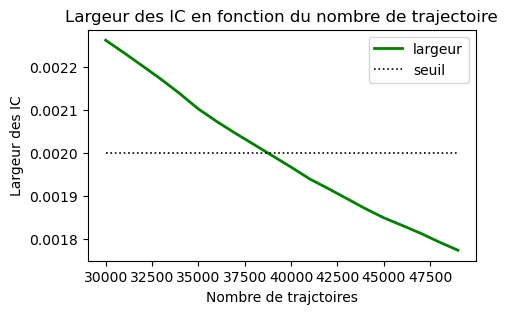

In [59]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 30000
delta_n = 1000
nb = 20
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs = np.zeros((nb,4))

###########################################################
#            Variable aléatoire et remplissage            #
###########################################################

P = anti(sigma1, sigma2, S10, S20, alpha, beta, rho, r, T, fin-1, [], [],  True)

for j in range(nb):
    erreurs[j] = intervalle_confiance_90(P[0:x0[j+1]]) 
    
largeurs = 2*erreurs[:,3]

###########################################################
#                        Graphique                        #
###########################################################

plt.figure(figsize = (5, 3))
plt.title('Largeur des IC en fonction du nombre de trajectoire')
plt.plot(x, largeurs, color = 'green', linewidth = 2, label = 'largeur')
plt.plot(x, 0.002*np.ones(np.size(x)), color = 'k', linewidth = 1.2, linestyle = ':', label = 'seuil')
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Largeur des IC')
plt.legend()
plt.show()

En modélisant $50000$ trajectoires avec une réduction de variance, on obtient des intervalles de confiance assez précis à partir de $N=40000$ trajectoires. En effet, à partir de ce nombre, l'intervalle de confiance reste sous la barre des $2\times10^{-3}$.

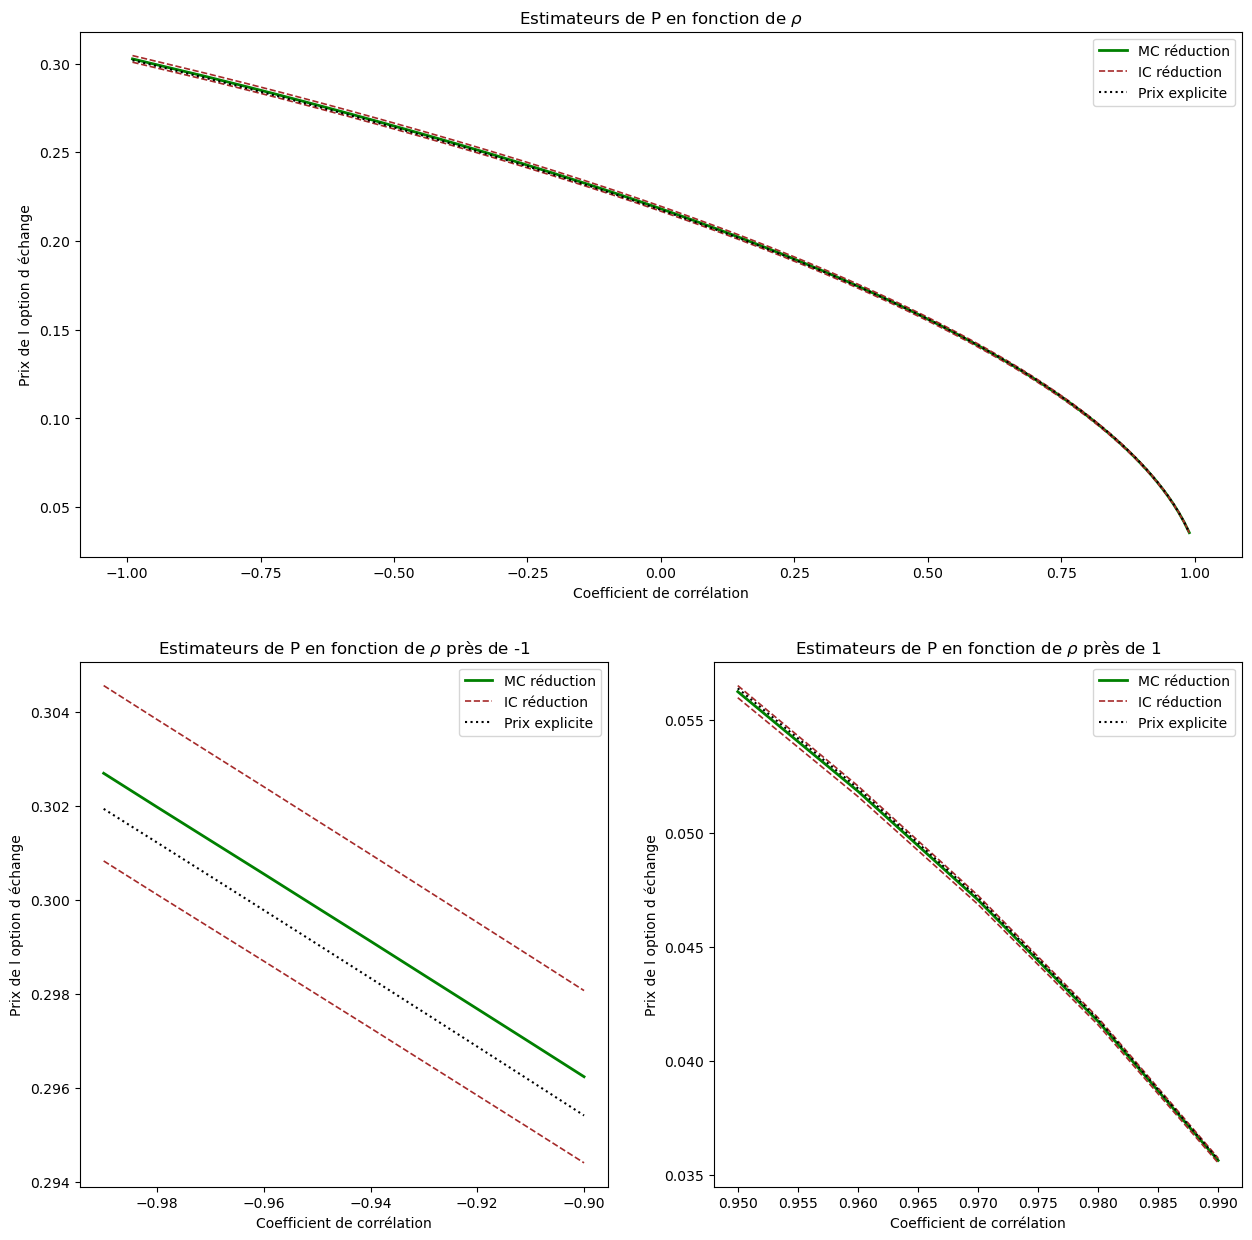

In [60]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

# Nombre de trajectoires pour une estimation assez précise
N = 40000

dn = 0.01
Vrho = np.arange(-1+dn, 1, dn)
s = np.size(Vrho)
erreurs = np.zeros((s,4))
Vexpl = np.zeros(s)

###########################################################
#            Variable aléatoire et remplissage            #
###########################################################

W1, W3 = couple_independant(T, N)

# Boucle de remplissage
for k in range(s):
    Wp = ( W1,  Vrho[k]*W1 + np.sqrt(1-Vrho[k]**2)*W3)  
    Wm = (-W1, -Vrho[k]*W1 - np.sqrt(1-Vrho[k]**2)*W3)
    # Prix avec réduction de variance
    P = anti(sigma1, sigma2, S10, S20, alpha, beta, Vrho[k], r, T, N, Wp, Wm,  True)
    erreurs[k] = intervalle_confiance_90(P)
    # Prix explicite
    hatsigma2 = sigma1**2 + sigma2**2 - 2*sigma1*sigma2*Vrho[k]
    d1 = (np.log((alpha*S10)/(beta*S20)) + (hatsigma2*T/2)) / np.sqrt(hatsigma2*T)
    d2 = d1 - np.sqrt(hatsigma2*T)
    Vexpl[k] = alpha*S10*psi(d1) - beta*S20*psi(d2)
    
###########################################################
#                        Graphique                        #
###########################################################

fig = plt.figure(figsize = (15, 15))
grid = plt.GridSpec(2, 2)

moy = erreurs[:,0]
ICg = erreurs[:,1]
ICd = erreurs[:,2]

# Global
ax1 = fig.add_subplot(grid[0, :])
ax1.set_title(r'Estimateurs de P en fonction de $\rho$')
# MC réduction
ax1.plot(Vrho, moy, color = 'green', linewidth = 2, label = 'MC réduction')
ax1.plot(Vrho, ICg, color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
ax1.plot(Vrho, ICd, color = 'brown', linewidth = 1.2, linestyle = '--')
# Prix explicite
ax1.plot(Vrho, Vexpl, color = 'black', 
         linewidth = 1.5, linestyle = ':', label = 'Prix explicite')
# Légende
ax1.set_xlabel('Coefficient de corrélation')
ax1.set_ylabel('Prix de l option d échange')
ax1.legend()

# Zoom à gauche
ax2 = fig.add_subplot(grid[1, 0])
ax2.set_title(r'Estimateurs de P en fonction de $\rho$ près de -1')
# MC réduction
ax2.plot(Vrho[0:10], moy[0:10], color = 'green', linewidth = 2, label = 'MC réduction')
ax2.plot(Vrho[0:10], ICg[0:10], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
ax2.plot(Vrho[0:10], ICd[0:10], color = 'brown', linewidth = 1.2, linestyle = '--')
# Prix explicite
ax2.plot(Vrho[0:10], Vexpl[0:10], color = 'black', 
         linewidth = 1.5, linestyle = ':', label = 'Prix explicite')
# Légende
ax2.set_xlabel('Coefficient de corrélation')
ax2.set_ylabel('Prix de l option d échange')
ax2.legend()

# Zoom à droite
ax3 = fig.add_subplot(grid[1, 1])
ax3.set_title(r'Estimateurs de P en fonction de $\rho$ près de 1')
# MC réduction
ax3.plot(Vrho[-5:], moy[-5:], color = 'green', linewidth = 2, label = 'MC réduction')
ax3.plot(Vrho[-5:], ICg[-5:], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
ax3.plot(Vrho[-5:], ICd[-5:], color = 'brown', linewidth = 1.2, linestyle = '--')
# Prix explicite
ax3.plot(Vrho[-5:], Vexpl[-5:], color = 'black', 
         linewidth = 1.5, linestyle = ':', label = 'Prix explicite')
# Légende
ax3.set_xlabel('Coefficient de corrélation')
ax3.set_ylabel('Prix de l option d échange')
ax3.legend()

plt.show()

### $\bullet\quad \mathcal{Commentaires}$ 

En étudiant la courbe de prix de l'option d'échange en fonction du coefficient de corrélation $\rho$, nous constatons que le prix de l'option décroît à mesure que la corrélation entre les deux actifs augmente. En effet, lorsque $\rho$ tend vers $1$, cela signifie que les deux actifs sont fortement corrélés, ce qui entraîne une réduction de l'écart entre eux et donc une diminution de la valeur de l'option. À l'inverse, lorsque $\rho$ tend vers $-1$, les deux actifs évoluent en sens opposé, ce qui augmente l'écart entre eux et donc le prix de l'option.

La réduction de la variance observée lorsque la corrélation entre les deux actifs augmente est due au fait que les mouvements browniens sous-jacents ont tendance à se compenser davantage lorsque la corrélation augmente. Cela signifie qu'il y a une diminution de l'incertitude sur la différence entre les deux actifs, ce qui conduit à une réduction de la variance du prix de l'option d'échange. En effet, lorsque les mouvements browniens sont très corrélés, le prix de l'option dépend principalement de la différence entre les deux actifs, qui est plus stable et prévisible lorsque la corrélation est forte. Cela permet d'obtenir des estimations plus précises et donc une réduction de la variance associée à ces estimations. En revanche, lorsque les mouvements browniens sont peu corrélés, le prix de l'option dépend davantage de la somme des deux actifs, ce qui est plus volatile et difficile à estimer, conduisant ainsi à une augmentation de la variance.

# $\mathcal{Question~7}$

Nous allons maintenant inclure un strike à l'option précédemment étudiée afin d'obtenir une option sur spread, et nous allons également mettre à jour les constantes initiales. Ensuite, nous allons implémenter les méthodes de Monte Carlo étudiées dans ce nouveau contexte.

### $\bullet\quad \mathcal{Données}$ 

In [61]:
sigma1, sigma2 = 0.25, 0.3
S10, S20 = 1, 1
alpha, beta = 1.2, 1
K = 0.2
rho = 0.5
r = 0.01
T = 2

def payoff_cond(sigmac, S0c, Kc, r, T):
    # Constantes d1 et d2
    if Kc > 0:
        d1c = (np.log(Kc/S0c) - (r - 0.5*sigmac**2)*T) / (sigmac*np.sqrt(T))
        d2c = d1c - sigmac*np.sqrt(T)
    else:
        d1c, d2c = 0, 0
    # Payoff
    if d2c == 0:
        phi = 0
    else:
        phi = Kc*np.exp(-r*T)*vpsi(d1c) - S0c*vpsi(d2c)
    return phi

vphi = np.vectorize(payoff_cond)

### $\bullet\quad \mathcal{Méthodes\ de\ Monte\ Carlo}$ 

In [62]:
##########################################################
#                      MC Classique                      #
##########################################################

def class_K(N):
    Z = couple_independant(T, N)
    t = T*np.ones(N)
    W = (Z[0], rho*Z[0] + np.sqrt(1-rho**2)*Z[1])
    S = np.array([S10*np.exp((r-0.5*sigma1**2)*t + sigma1*W[0]),
                  S20*np.exp((r-0.5*sigma2**2)*t + sigma2*W[1])])
    diff = np.maximum(alpha*S[0,:] - beta*S[1,:] - K, 0)
    return np.exp(-r*T)*np.mean(diff)

##########################################################
#        MC Réduction de variance - Conditionnement      #
##########################################################

def cond_K(sigma1, sigma2, S10, S20, alpha, beta, K, rho, r, T, N, W1 = [], vec = False):
    # Prix par Monte-Carlo - Semi Box-Muller
    if np.size(W1) == 0:
        W1 = np.sqrt(T)*np.sqrt(-2*np.log(rand.random(N)))*np.cos(2*np.pi*rand.random(N))
    # Variables
    S0c = beta*S20*np.exp(rho*sigma2*W1 - 0.5*T*(rho*sigma2)**2)
    sigmac = sigma2*np.sqrt(1-rho**2)
    Kc = alpha*S10*np.exp(sigma1*W1 + (r - 0.5*sigma1**2)*T) - K
    phi = vphi(sigmac, S0c, Kc, r, T)
    
    # Payoff
    if vec:
        return phi
    
    # Prix
    return np.mean(phi)

##########################################################
#   MC Réduction de variance - Variables antithétiques   #
##########################################################

def anti_K(sigma1, sigma2, S10, S20, alpha, beta, K, rho, r, T, N, Wp = [], Wm = [], vec = False):
    if np.size(Wp) == 0 or np.size(Wm) == 0:
        Z = couple_independant(T, N)
        # Mouvements browniens corrélés 
        Wp = ( Z[0],  rho*Z[0] + np.sqrt(1-rho**2)*Z[1])  
        Wm = (-Z[0], -rho*Z[0] - np.sqrt(1-rho**2)*Z[1])
    # Vecteurs des sous-jacents
    t = T*np.ones(N)
    Sp = np.array([S10*np.exp((r-0.5*sigma1**2)*t + sigma1*Wp[0]), S20*np.exp((r-0.5*sigma2**2)*t + sigma2*Wp[1])])
    Sm = np.array([S10*np.exp((r-0.5*sigma1**2)*t + sigma1*Wm[0]), S20*np.exp((r-0.5*sigma2**2)*t + sigma2*Wm[1])])
    # Options d'échange
    diffp = np.maximum(alpha*Sp[0,:] - beta*Sp[1,:] - K, 0)
    diffm = np.maximum(alpha*Sm[0,:] - beta*Sm[1,:] - K, 0)
    diff = np.exp(-r*T)*(diffp + diffm) / 2
    
    # Payoff
    if vec:
        return diff
    
    # Prix de l'option 
    return np.mean(diff)

### $\bullet\quad \mathcal{Comparaison}$ 

In [63]:
Prix_K = class_K(90000)
Prixc_K = cond_K(sigma1, sigma2, S10, S20, alpha, beta, K, rho, r, T, 90000)
Prixa_K = anti_K(sigma1, sigma2, S10, S20, alpha, beta, K, rho, r, T, 90000)
print('Prix MC class. : ', Prix_K)
print('Prix MC condi. : ', Prixc_K)
print('Prix MC antit. : ', Prixc_K)

Prix MC class. :  0.16801370019887504
Prix MC condi. :  0.16982510681936702
Prix MC antit. :  0.16982510681936702


Les résultats semblent similaires, ce qui suggère que les nouvelles méthodes ont été correctement implémentées. Pour confirmer cette hypothèse, on peut faire de même que pour l'option d'échange. Par ailleurs, il est conseillé de tester le programme avec différentes valeurs de paramètres afin de s'assurer de sa robustesse et de sa capacité à fonctionner correctement pour une variété de scénarios. Dans notre cas, nous ferons varier les paramètres $\rho$, $K$, et $\sigma$ dans les questions suivantes.

# $\mathcal{Question~8}$

Nous allons maintenant tracer les estimateurs de prix en fonction du nombre de trajectoires pour les deux méthodes de réduction de variance afin d'avoir un point de comparaison et de ne pas privilégier la méthode basée sur le conditionnement.

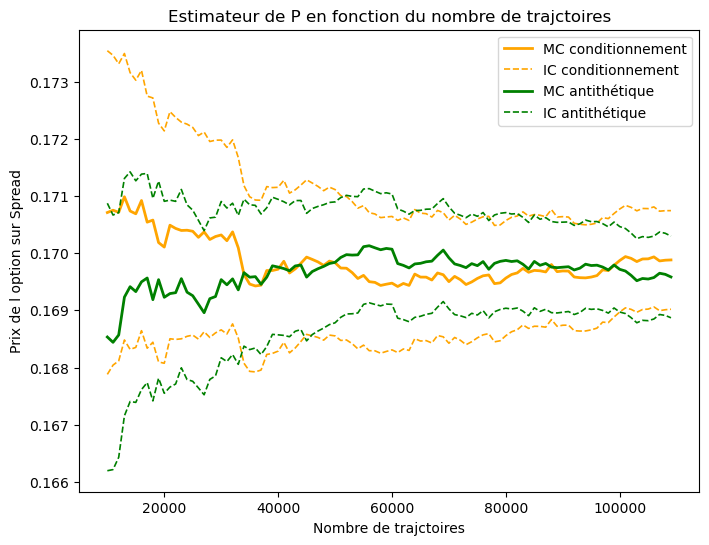

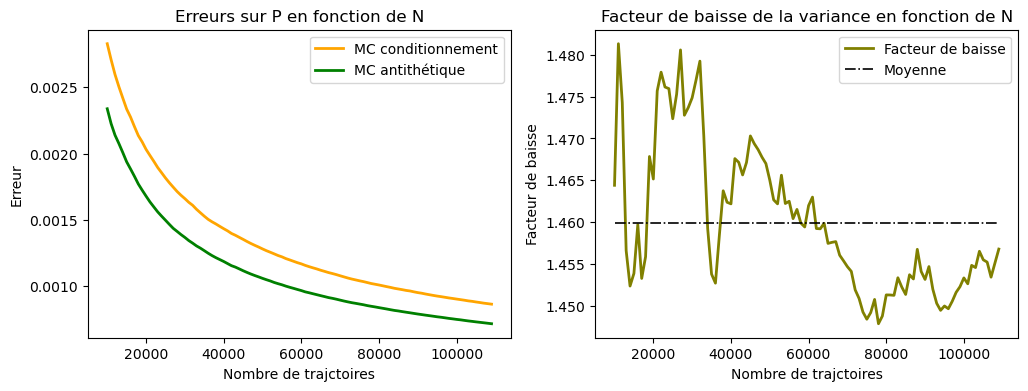

Facteur de baisse :  1.4599430858999884


In [64]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 10000
delta_n = 1000
nb = 100
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs1 = np.zeros((nb,4))
erreurs2 = np.zeros((nb,4))

###########################################################
#           Variables aléatoires et remplissage           #
###########################################################

W1, W3 = couple_independant(T, fin-1)
Wp = ( W1,  rho*W1 + np.sqrt(1-rho**2)*W3)  
Wm = (-W1, -rho*W1 - np.sqrt(1-rho**2)*W3)

P1 = cond_K(sigma1, sigma2, S10, S20, alpha, beta, K, rho, r, T, fin-1, W1, True)
P2 = anti_K(sigma1, sigma2, S10, S20, alpha, beta, K, rho, r, T, fin-1, Wp, Wm, True)

for j in range(nb):
    erreurs1[j] = intervalle_confiance_90(P1[0:x0[j+1]])
    erreurs2[j] = intervalle_confiance_90(P2[0:x0[j+1]])

###########################################################
#                Graphique des estimateurs                #
###########################################################

plt.figure(figsize = (8, 6))
plt.title('Estimateur de P en fonction du nombre de trajctoires')
# MC conditionnement
plt.plot(x, erreurs1[:,0], color = 'orange', linewidth = 2, label = 'MC conditionnement')
plt.plot(x, erreurs1[:,1], color = 'orange', linewidth = 1.2, linestyle = '--', label = 'IC conditionnement')
plt.plot(x, erreurs1[:,2], color = 'orange', linewidth = 1.2, linestyle = '--')
# MC antithétique
plt.plot(x, erreurs2[:,0], color = 'green', linewidth = 2, label = 'MC antithétique')
plt.plot(x, erreurs2[:,1], color = 'green', linewidth = 1.2, linestyle = '--', label = 'IC antithétique')
plt.plot(x, erreurs2[:,2], color = 'green', linewidth = 1.2, linestyle = '--')
# Légende
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Prix de l option sur Spread')
plt.legend()
plt.show()

###########################################################
#                  Graphique des erreurs                  #
###########################################################

fig = plt.figure(figsize = (12, 4))
grid = plt.GridSpec(2, 2)

ax1 = fig.add_subplot(grid[:, 0])
ax1.set_title('Erreurs sur P en fonction de N')
# MC classique
ax1.plot(x, erreurs1[:,3], color = 'orange', linewidth = 2, label = 'MC conditionnement')
# MC réduction
ax1.plot(x, erreurs2[:,3], color = 'green', linewidth = 2, label = 'MC antithétique')
# Légende
ax1.set_xlabel('Nombre de trajctoires')
ax1.set_ylabel('Erreur')
ax1.legend()

ax2 = fig.add_subplot(grid[:, 1])
ax2.set_title('Facteur de baisse de la variance en fonction de N')
Baisse = (erreurs1[:,3]/erreurs2[:,3])**2
ecart = np.mean(Baisse)
ax2.plot(x, Baisse, color = 'olive', linewidth = 2, label = 'Facteur de baisse')
ax2.plot(x, np.ones(nb)*np.mean(Baisse), color = 'k', linewidth = 1.2, linestyle = '-.', label = 'Moyenne')
ax2.set_xlabel('Nombre de trajctoires')
ax2.set_ylabel('Facteur de baisse')
ax2.legend()

plt.show()

# Réduction de la variance ? 
print('Facteur de baisse : ', ecart)

En comparant les résultats obtenus par les méthodes de Monte-Carlo de réduction de variance, il a été observé que les deux méthodes permettaient d'obtenir une estimation du prix de l'option sur spread proche du prix explicite. En outre, l'intervalle de confiance associé à chaque estimation a diminué à mesure que le nombre de trajectoires augmentait, tout en maintenant le prix explicite à l'intérieur de l'intervalle.

Cependant, avec les constantes initiales utilisées, il a été constaté que la méthode de réduction de variance avec variables antithétiques était plus efficace que la méthode basée sur le conditionnement, pour l'estimation du prix de l'option sur spread, comme l'indique la réduction de la variance obtenue avec cette méthode.

# $\mathcal{Question~9}$

Pour choisir un nombre de trajectoires pour lequel l'estimation avec réduction de variance est assez précise, on peut fixer un critère tel que la largeur de l'intervalle de confiance soit inférieure à un certain seuil $\varepsilon$. Par exemple, on peut choisir $\varepsilon = 2\times10^{-2}$ pour avoir une précision à deux décimales près. Si une précision à trois décimales près était nécessaire, il faudrait utiliser un nombre de trajectoires beaucoup plus élevé, ce qui pourrait prendre plus de temps de calcul.

### $\bullet\quad \mathcal{Technique\ basée\ sur\ le\ conditionnement}$ 

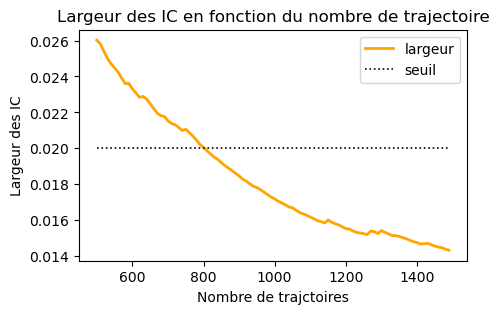

In [65]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 500
delta_n = 10
nb = 100
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs = np.zeros((nb,4))

###########################################################
#            Variable aléatoire et remplissage            #
###########################################################

P = cond_K(sigma1, sigma2, S10, S20, alpha, beta, K, rho, r, T, fin-1, [], True)

for j in range(nb):
    erreurs[j] = intervalle_confiance_90(P[0:x0[j+1]]) 
    
largeurs = 2*erreurs[:,3]

###########################################################
#                        Graphique                        #
###########################################################

plt.figure(figsize = (5, 3))
plt.title('Largeur des IC en fonction du nombre de trajectoire')
plt.plot(x, largeurs, color = 'orange', linewidth = 2, label = 'largeur')
plt.plot(x, 0.02*np.ones(np.size(x)), color = 'k', linewidth = 1.2, linestyle = ':', label = 'seuil')
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Largeur des IC')
plt.legend()
plt.show()

En modélisant $1500$ trajectoires avec une réduction de variance, on obtient des intervalles de confiance assez précis à partir de $N=1000$ trajectoires. En effet, à partir de ce nombre, l'intervalle de confiance reste sous la barre des $2\times10^{-2}$.

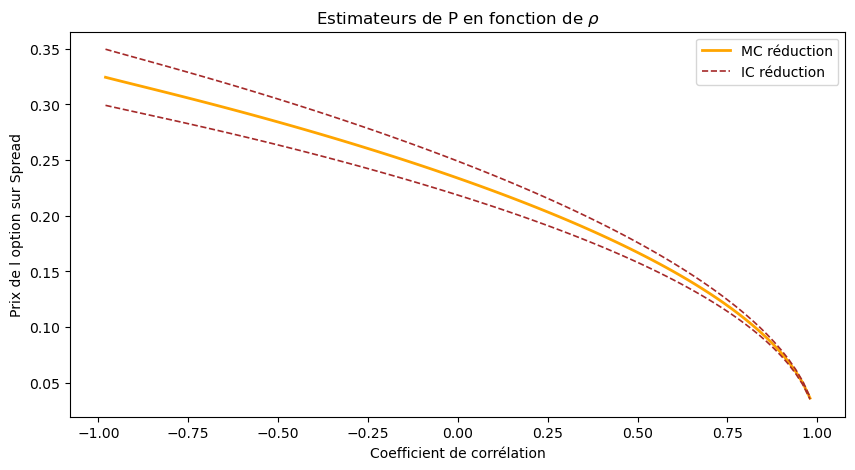

In [66]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

# Nombre de trajectoires pour une estimation assez précise
N = 1000

dn = 0.02
Vrho = np.arange(-1+dn, 1, dn)
s = np.size(Vrho)
erreurs = np.zeros((s,4))

###########################################################
#            Variable aléatoire et remplissage            #
###########################################################

W = np.sqrt(T)*np.sqrt(-2*np.log(rand.random(N)))*np.cos(2*np.pi*rand.random(N))

# Boucle de remplissage
for k in range(s):
    # Prix avec réduction de variance
    P = cond_K(sigma1, sigma2, S10, S20, alpha, beta, K, Vrho[k], r, T, N, W,  True)
    erreurs[k] = intervalle_confiance_90(P)
    
###########################################################
#                        Graphique                        #
###########################################################

fig = plt.figure(figsize = (10, 5))
plt.title(r'Estimateurs de P en fonction de $\rho$')
# MC réduction
plt.plot(Vrho, erreurs[:,0], color = 'orange', linewidth = 2, label = 'MC réduction')
plt.plot(Vrho, erreurs[:,1], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
plt.plot(Vrho, erreurs[:,2], color = 'brown', linewidth = 1.2, linestyle = '--')
# Légende
plt.xlabel('Coefficient de corrélation')
plt.ylabel('Prix de l option sur Spread')
plt.legend()
plt.show()

### $\bullet\quad \mathcal{Technique\ de\ variables\ antithétiques}$ 

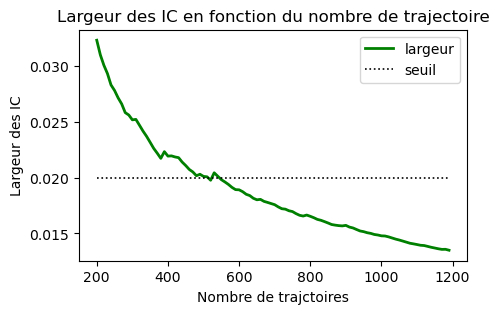

In [67]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 200
delta_n = 10
nb = 100
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs = np.zeros((nb,4))

###########################################################
#            Variable aléatoire et remplissage            #
###########################################################

P = anti_K(sigma1, sigma2, S10, S20, alpha, beta, K, rho, r, T, fin-1, [], [], True)

for j in range(nb):
    erreurs[j] = intervalle_confiance_90(P[0:x0[j+1]]) 
    
largeurs = 2*erreurs[:,3]

###########################################################
#                        Graphique                        #
###########################################################

plt.figure(figsize = (5, 3))
plt.title('Largeur des IC en fonction du nombre de trajectoire')
plt.plot(x, largeurs, color = 'green', linewidth = 2, label = 'largeur')
plt.plot(x, 0.02*np.ones(np.size(x)), color = 'k', linewidth = 1.2, linestyle = ':', label = 'seuil')
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Largeur des IC')
plt.legend()
plt.show()

En modélisant $1200$ trajectoires avec une réduction de variance, on obtient des intervalles de confiance assez précis à partir de $N=600$ trajectoires. En effet, à partir de ce nombre, l'intervalle de confiance reste sous la barre des $2\times10^{-2}$.

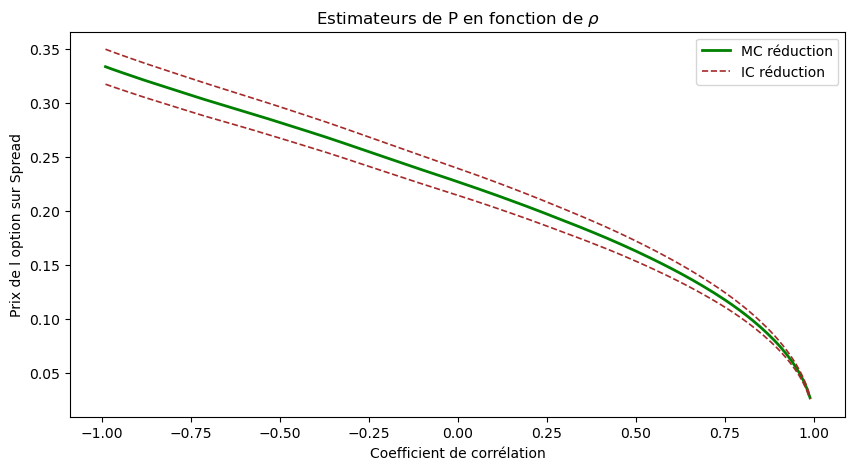

In [68]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

# Nombre de trajectoires pour une estimation assez précise
N = 600

dn = 0.01
Vrho = np.arange(-1+dn, 1, dn)
s = np.size(Vrho)
erreurs = np.zeros((s,4))

###########################################################
#           Variables aléatoires et remplissage           #
###########################################################

W1, W3 = couple_independant(T, N)

# Boucle de remplissage
for k in range(s):
    Wp = ( W1,  Vrho[k]*W1 + np.sqrt(1-Vrho[k]**2)*W3)  
    Wm = (-W1, -Vrho[k]*W1 - np.sqrt(1-Vrho[k]**2)*W3)
    # Prix avec réduction de variance
    P = anti_K(sigma1, sigma2, S10, S20, alpha, beta, K, Vrho[k], r, T, N, Wp, Wm, True)
    erreurs[k] = intervalle_confiance_90(P)
    
###########################################################
#                        Graphique                        #
###########################################################

fig = plt.figure(figsize = (10, 5))
plt.title(r'Estimateurs de P en fonction de $\rho$')
# MC réduction
plt.plot(Vrho, erreurs[:,0], color = 'green', linewidth = 2, label = 'MC réduction')
plt.plot(Vrho, erreurs[:,1], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
plt.plot(Vrho, erreurs[:,2], color = 'brown', linewidth = 1.2, linestyle = '--')
# Légende
plt.xlabel('Coefficient de corrélation')
plt.ylabel('Prix de l option sur Spread')
plt.legend()
plt.show()

### $\bullet\quad \mathcal{Commentaires}$ 

En maintenant le strike constant, nous pouvons appliquer les mêmes observations que pour l'évolution des estimateurs du prix de l'option d'échange en fonction du coefficient de corrélation. Cela nous permet de constater comment la corrélation affecte le prix de l'option sur spread et les performances des méthodes de Monte Carlo étudiées.

Cependant, il est important de noter que l'évolution du prix de l'option sur spread peut différer de celle de l'option d'échange, en raison de la présence d'un strike. De plus, les résultats obtenus pour le prix de l'option sur spread peuvent être influencés par les constantes initiales choisies et la méthode de Monte Carlo utilisée.

# $\mathcal{Question~10}$

Nous allons tracer les estimations du prix en fonction du Strike en utilisant les mêmes critères de précision que précédemment, pour permettre une comparaison juste entre les deux méthodes de réduction de variance.

### $\bullet\quad \mathcal{Technique\ basée\ sur\ le\ conditionnement}$ 

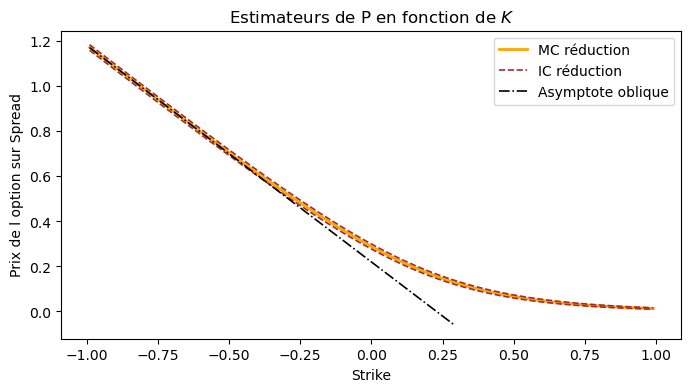

Asymptote oblique :  -0.96154 K + 0.22


In [69]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

# Nombre de trajectoires pour une estimation assez précise
N = 1000

dn = 0.01
VK = np.arange(-1+dn, 1, dn)
s = np.size(VK)
erreurs = np.zeros((s,4))

###########################################################
#            Variable aléatoire et remplissage            #
###########################################################

W = np.sqrt(T)*np.sqrt(-2*np.log(rand.random(N)))*np.cos(2*np.pi*rand.random(N))

# Boucle de remplissage
for k in range(s):
    # Prix avec réduction de variance
    P = cond_K(sigma1, sigma2, S10, S20, alpha, beta, VK[k], rho, r, T, N, W, True)
    erreurs[k] = intervalle_confiance_90(P)
    
moy = erreurs[:,0]
ICg = erreurs[:,1]
ICd = erreurs[:,2]
    
###########################################################
#                    Asymptote oblique                    #
###########################################################
    
Igauche = int(np.floor(s/6))
VKgauche = VK[0:Igauche]
Prixgauche = moy[0:Igauche]
a, b = np.polyfit(VKgauche, Prixgauche, 1)
Iasym = int(np.floor(3.25*s/5))
VKasym = VK[0:Iasym]
Asymgauche = a*VK[0:Iasym] + b
    
###########################################################
#                        Graphique                        #
###########################################################

fig = plt.figure(figsize = (8, 4))
plt.title(r'Estimateurs de P en fonction de $K$')
# MC réduction
plt.plot(VK, moy, color = 'orange', linewidth = 2, label = 'MC réduction')
plt.plot(VK, ICg, color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
plt.plot(VK, ICd, color = 'brown', linewidth = 1.2, linestyle = '--')
# Asymptote 
plt.plot(VKasym, Asymgauche, color = 'k', linewidth = 1.2, linestyle = '-.', label = 'Asymptote oblique')
# Légende
plt.xlabel('Strike')
plt.ylabel('Prix de l option sur Spread')
plt.legend()
plt.show()

# Asymptote
print('Asymptote oblique : ', round(a,5), 'K +', round(b,5))

### $\bullet\quad \mathcal{Technique\ de\ variables\ antithétiques}$ 

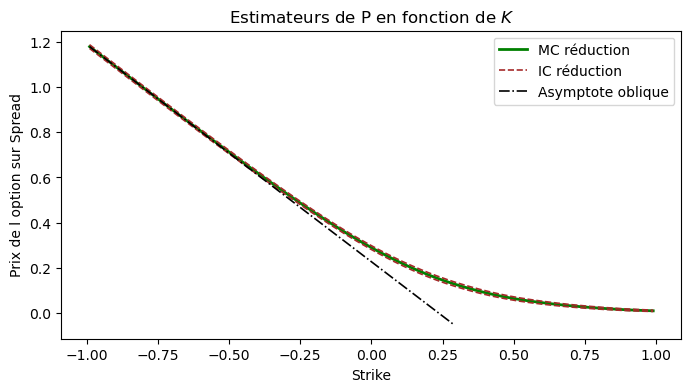

Asymptote oblique :  -0.96167 K + 0.22708


In [70]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

# Nombre de trajectoires pour une estimation assez précise
N = 600

dn = 0.01
VK = np.arange(-1+dn, 1, dn)
s = np.size(VK)
erreurs = np.zeros((s,4))

###########################################################
#            Variable aléatoire et remplissage            #
###########################################################

W1, W3 = couple_independant(T, N)
Wp = ( W1,  rho*W1 + np.sqrt(1-rho**2)*W3)  
Wm = (-W1, -rho*W1 - np.sqrt(1-rho**2)*W3)
    
# Boucle de remplissage
for k in range(s):
    # Prix avec réduction de variance
    P = anti_K(sigma1, sigma2, S10, S20, alpha, beta, VK[k], rho, r, T, N, Wp, Wm, True)
    erreurs[k] = intervalle_confiance_90(P)
    
moy = erreurs[:,0]
ICg = erreurs[:,1]
ICd = erreurs[:,2]
    
###########################################################
#                    Asymptote oblique                    #
###########################################################
    
Igauche = int(np.floor(s/6))
VKgauche = VK[0:Igauche]
Prixgauche = moy[0:Igauche]
a, b = np.polyfit(VKgauche, Prixgauche, 1)
Iasym = int(np.floor(3.25*s/5))
VKasym = VK[0:Iasym]
Asymgauche = a*VK[0:Iasym] + b
    
###########################################################
#                        Graphique                        #
###########################################################

fig = plt.figure(figsize = (8, 4))
plt.title(r'Estimateurs de P en fonction de $K$')
# MC réduction
plt.plot(VK, moy, color = 'green', linewidth = 2, label = 'MC réduction')
plt.plot(VK, ICg, color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
plt.plot(VK, ICd, color = 'brown', linewidth = 1.2, linestyle = '--')
# Asymptote 
plt.plot(VKasym, Asymgauche, color = 'k', linewidth = 1.2, linestyle = '-.', label = 'Asymptote oblique')
# Légende
plt.xlabel('Strike')
plt.ylabel('Prix de l option sur Spread')
plt.legend()
plt.show()

# Asymptote
print('Asymptote oblique : ', round(a,5), 'K +', round(b,5))

### $\bullet\quad \mathcal{Commentaires}$ 

En analysant l'évolution du prix de l'option sur spread en fonction du strike, nous constatons toujours une tendance à la décroissance. Cependant, cette tendance est différente de celle observée précédemment. Lorsque le strike $K$ diminue, le prix augmente de manière affine avec une asymptote oblique d'une pente d'environ $-1$, ce qui signifie que le prix tend vers l'infini lorsque $-K$ tend vers l'infini. En revanche, lorsqu'on augmente le strike, le prix est borné par $0$ en raison de la partie positive prise sur le payoff. Ainsi, cette fois-ci, nous avons une asymptote horizontale car lorsque $-K$ tend vers $-\infty$, la partie positive sera nulle.

# $\mathcal{Question~11}$

Désormais, nous allons mettre en œuvre une autre méthode de réduction de variance par variables de contrôle, qui utilise la parité entre les options d'achat et de vente. Les explications détaillées se trouvent dans le rapport.

In [71]:
def cont_K(N, sig1 = sigma1, sig2 = sigma2, W = [], vec = True):
    if np.size(W) == 0:
        W = couple_correle(T, N)
    t = T*np.ones(N)
    S = np.array([S10*np.exp((r-0.5*sig1**2)*t + sig1*W[0]), S20*np.exp((r-0.5*sig2**2)*t + sig2*W[1])])
    call = np.exp(-r*T)*np.maximum(alpha*S[0,:] - beta*S[1,:] - K, 0)
    put = np.exp(-r*T)*np.maximum(-alpha*S[0,:] + beta*S[1,:] + K, 0) + alpha*S10 - beta*S20 - K*np.exp(-r*T)
    
    if vec:
        return call, put 
        
    return np.mean(call), np.mean(put)

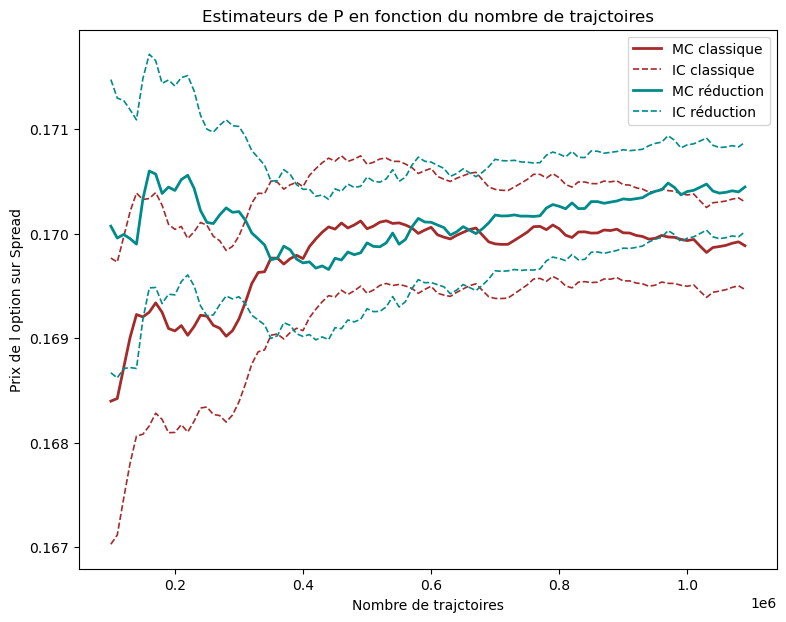

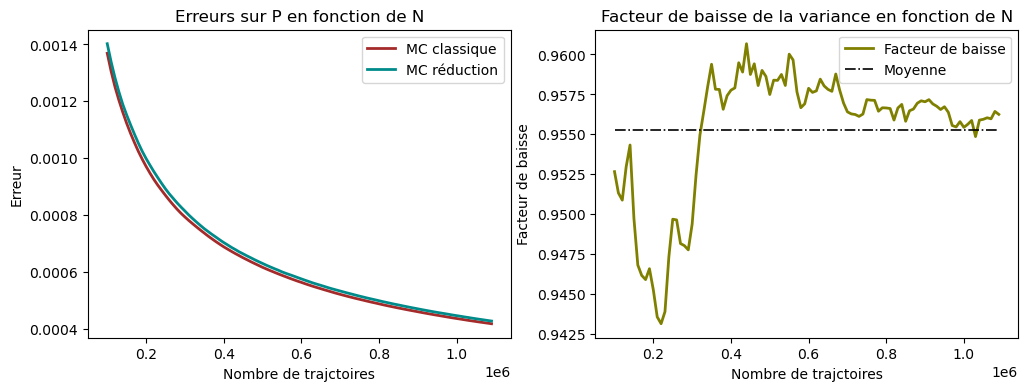

Facteur de baisse :  0.9552782119577549


In [73]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 100000
delta_n = 10000
nb = 100
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs1 = np.zeros((nb,4))
erreurs2 = np.zeros((nb,4))

###########################################################
#           Variables aléatoires et remplissage           #
###########################################################

call, put = cont_K(fin-1)

for j in range(nb):
    erreurs1[j] = intervalle_confiance_90(call[0:x0[j+1]])
    erreurs2[j] = intervalle_confiance_90(put[0:x0[j+1]])

###########################################################
#                Graphique des estimateurs                #
###########################################################

plt.figure(figsize = (9, 7))
plt.title('Estimateurs de P en fonction du nombre de trajctoires')
# MC classique
plt.plot(x, erreurs1[:,0], color = 'brown', linewidth = 2, label = 'MC classique')
plt.plot(x, erreurs1[:,1], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC classique')
plt.plot(x, erreurs1[:,2], color = 'brown', linewidth = 1.2, linestyle = '--')
# MC réduction
plt.plot(x, erreurs2[:,0], color = 'darkcyan', linewidth = 2, label = 'MC réduction')
plt.plot(x, erreurs2[:,1], color = 'darkcyan', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
plt.plot(x, erreurs2[:,2], color = 'darkcyan', linewidth = 1.2, linestyle = '--')
# Légende
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Prix de l option sur Spread')
plt.legend()
plt.show()

###########################################################
#                  Graphique des erreurs                  #
###########################################################

fig = plt.figure(figsize = (12, 4))
grid = plt.GridSpec(2, 2)

ax1 = fig.add_subplot(grid[:, 0])
ax1.set_title('Erreurs sur P en fonction de N')
# MC classique
ax1.plot(x, erreurs1[:,3], color = 'brown', linewidth = 2, label = 'MC classique')
# MC réduction
ax1.plot(x, erreurs2[:,3], color = 'darkcyan', linewidth = 2, label = 'MC réduction')
# Légende
ax1.set_xlabel('Nombre de trajctoires')
ax1.set_ylabel('Erreur')
ax1.legend()

ax2 = fig.add_subplot(grid[:, 1])
ax2.set_title('Facteur de baisse de la variance en fonction de N')
Baisse = (erreurs1[:,3]/erreurs2[:,3])**2
ecart = np.mean(Baisse)
ax2.plot(x, Baisse, color = 'olive', linewidth = 2, label = 'Facteur de baisse')
ax2.plot(x, np.ones(nb)*np.mean(Baisse), color = 'k', linewidth = 1.2, linestyle = '-.', label = 'Moyenne')
ax2.set_xlabel('Nombre de trajctoires')
ax2.set_ylabel('Facteur de baisse')
ax2.legend()

plt.show()

# Réduction de la variance ? 
print('Facteur de baisse : ', ecart)

Nous avons constaté que la méthode de réduction de variance n'est pas efficace. En effet, en utilisant cette méthode pour modéliser le prix du put, dont les valeurs sont bornées, la variance augmente avec un facteur de baisse de seulement 0,96 par rapport à celle obtenue avec le call. Nous pensons que le problème vient du niveau de strike, c'est pourquoi nous allons examiner les estimateurs du prix en fonction du strike afin de déterminer à quel moment la variance commence à augmenter.

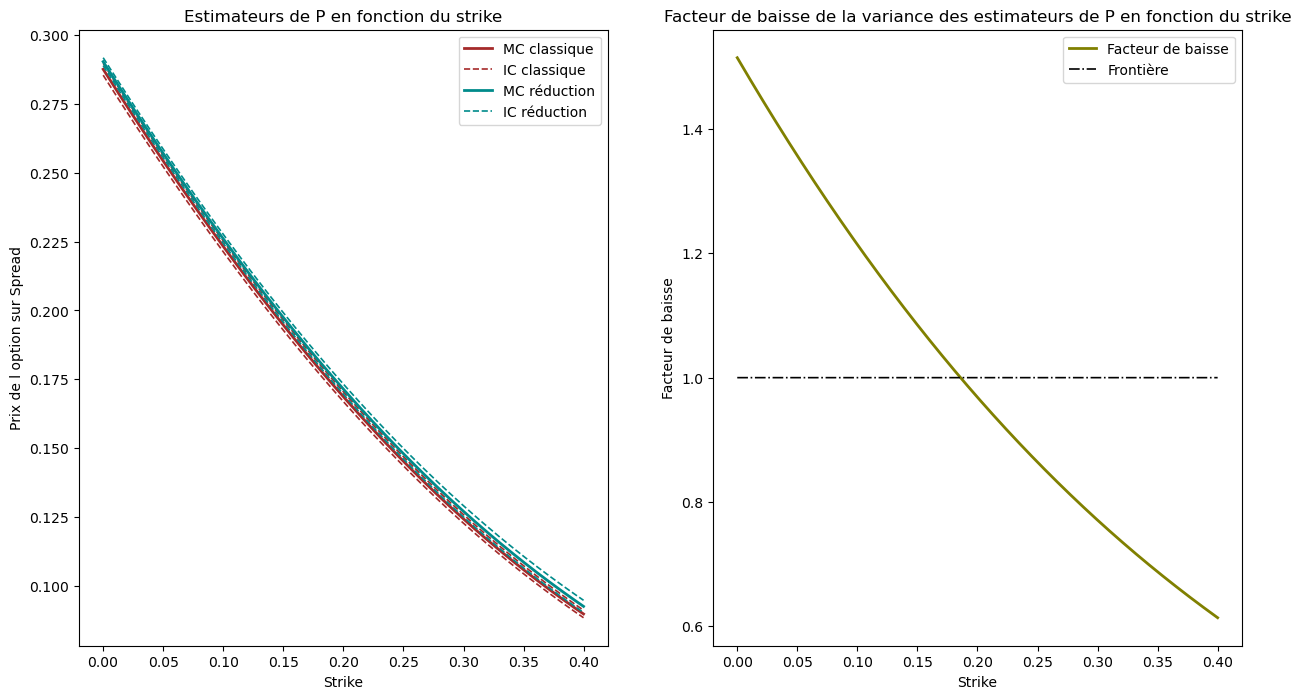

Point problématique :  0.186


In [75]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

fin = 60000
dn = 10**-4
VK = np.arange(dn, 0.4, dn)
s = np.size(VK)
erreurs1 = np.zeros((s,4))
erreurs2 = np.zeros((s,4))

###########################################################
#           Variables aléatoires et remplissage           #
###########################################################

S = cours_actifs(T, fin)

for j in range(s):
    call = np.exp(-r*T)*np.maximum(alpha*S[0,:] - beta*S[1,:] - VK[j], 0)
    put = np.exp(-r*T)*np.maximum(-alpha*S[0,:] + beta*S[1,:] + VK[j], 0) + alpha*S10 - beta*S20 - VK[j]*np.exp(-r*T)
    erreurs1[j] = intervalle_confiance_90(call)
    erreurs2[j] = intervalle_confiance_90(put)
    
###########################################################
#                    Facteur de baisse                    #
###########################################################
    
Baisse = erreurs1[:,3]/erreurs2[:,3]
Sup1 = np.maximum(Baisse, 1)
ind = np.argmin(Sup1)
PtFrVK = VK[ind]
PtFrBaisse = Baisse[ind]

###########################################################
#                Graphique des estimateurs                #
###########################################################

fig = plt.figure(figsize = (15, 8))
grid = plt.GridSpec(2, 2)

ax1 = fig.add_subplot(grid[:, 0])
ax1.set_title('Estimateurs de P en fonction du strike')
# MC classique
ax1.plot(VK, erreurs1[:,0], color = 'brown', linewidth = 2, label = 'MC classique')
ax1.plot(VK, erreurs1[:,1], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC classique')
ax1.plot(VK, erreurs1[:,2], color = 'brown', linewidth = 1.2, linestyle = '--')
# MC réduction
ax1.plot(VK, erreurs2[:,0], color = 'darkcyan', linewidth = 2, label = 'MC réduction')
ax1.plot(VK, erreurs2[:,1], color = 'darkcyan', linewidth = 1.2, linestyle = '--', label = 'IC réduction')
ax1.plot(VK, erreurs2[:,2], color = 'darkcyan', linewidth = 1.2, linestyle = '--')
# Légende
ax1.set_xlabel('Strike')
ax1.set_ylabel('Prix de l option sur Spread')
ax1.legend()

ax2 = fig.add_subplot(grid[:, 1])
ax2.set_title('Facteur de baisse de la variance des estimateurs de P en fonction du strike')
ax2.plot(VK, Baisse, color = 'olive', linewidth = 2, label = 'Facteur de baisse')
ax2.plot(VK, np.ones(s), color = 'k', linewidth = 1.2, linestyle = '-.', label = 'Frontière')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Facteur de baisse')
ax2.legend()

plt.show()

# Point problématique
print('Point problématique : ', PtFrVK)

Tout d'abord, nous remarquons que les prix restent similaires en raison de la superposition des courbes. Toutefois, la diminution de la variance n'est observée que jusqu'à un strike de $0.19$, ce qui explique pourquoi pour notre valeur de $K=0.2$, la méthode de "réduction de variance" n'a pas permis de réduire la variance mais plutôt de l'augmenter.

# $\mathcal{Question~12}$

Appliquons tout de même la méthode de réduction de variance utilisant la parité Call-Put pour modéliser (en 3D) le prix de l'option sur spread en fonction des volatilités.

In [76]:
#matplotlib notebook

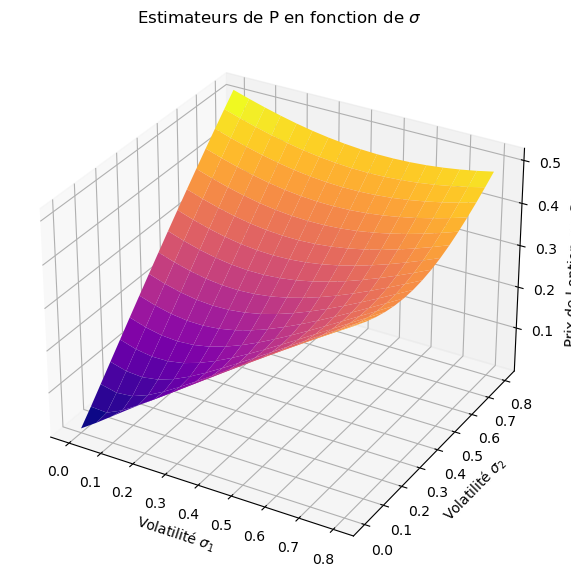

In [77]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

# Nombre de trajectoires pour une estimation assez précise
N = 85000

dn = 0.05
Vsigma1 = np.arange(0, 0.8+dn, dn)
Vsigma2 = np.arange(0, 0.8+dn, dn)
s1 = np.size(Vsigma1)
s2 = np.size(Vsigma2)
courbe = np.zeros((s1,s2))

###########################################################
#           Variables aléatoires et remplissage           #
###########################################################

W = couple_correle(T, N)

for j in range(s1):
    for k in range(s2):
        courbe[j,k] = cont_K(N, Vsigma1[j], Vsigma2[k], W, False)[1]
    
###########################################################
#                        Graphique                        #
###########################################################

x, y = np.meshgrid(Vsigma1, Vsigma2)

fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(111, projection = '3d')
plt.title(r'Estimateurs de P en fonction de $\sigma$')
ax.plot_surface(x, y, courbe, cmap = "plasma")
ax.set_xlabel(r'Volatilité $\sigma_1$')
ax.set_ylabel(r'Volatilité $\sigma_2$')
ax.set_zlabel('Prix de l option sur Spread')
plt.show()

De la même manière que pour l'étude de l'évolution du prix en fonction du coefficient de corrélation, l'analyse de l'évolution du prix en fonction des volatilités peut être expliquée en se référant à l'option d'échange. Nous pouvons donc considérer la nouvelle volatilité $\hat{\sigma}=\sqrt{\sigma_1^2+\sigma_2^2-2\sigma_1\sigma_2\rho}$ pour expliquer l'évolution du prix à $\rho$ et $K$ fixés.

Lorsque les deux volatilités sont nulles, le payoff est constant et le choix des constantes initiales donne un prix nul. En augmentant les volatilités, le prix augmente également, avec des pics aux maxima des volatilités. De plus, si l'on fixe une volatilité, l'évolution du prix en fonction de la seconde se fait de manière quadratique. Cela peut s'expliquer par la forme de $\hat{\sigma}^2$, qui est alors une fonction du second degré de la volatilité en question. 

# $\mathcal{Question~13}$

On peut obtenir une expression explicite du prix théorique du forward sur Best Of considéré par un calcul. Cette expression est donnée par la formule suivante : $$e^{-rT}\mathbb{E}\left[\max(S_1(T),S_2(T))-K\right]=S_{1,0}\psi(d_1)-S_{2,0}(\psi(d_2)-1)-Ke^{-rT}$$

In [78]:
hatsigmaBO = np.sqrt(sigma1**2 + sigma2**2 - 2*sigma1*sigma2*rho)
d1BO = (np.log(S10/S20) + 0.5*(hatsigmaBO**2)*T) / (hatsigmaBO*np.sqrt(T))
d2BO = d1BO - hatsigmaBO*np.sqrt(T)

def BestOf_th(K = 1):
    return S10*psi(d1BO) - S20*(psi(d2BO)-1) - K*np.exp(-r*T)

# $\mathcal{Question~14}$

Nous allons mettre en œuvre une méthode de Monte Carlo classique pour calculer le prix du forward sur Best Of, afin de vérifier si notre formule est exacte.

In [79]:
def BestOf_MC(N, K = 1):
    S = cours_actifs(T, N)
    payoff = np.exp(-r*T)*(np.maximum(S[0,:], S[1,:]) - K)
    return payoff

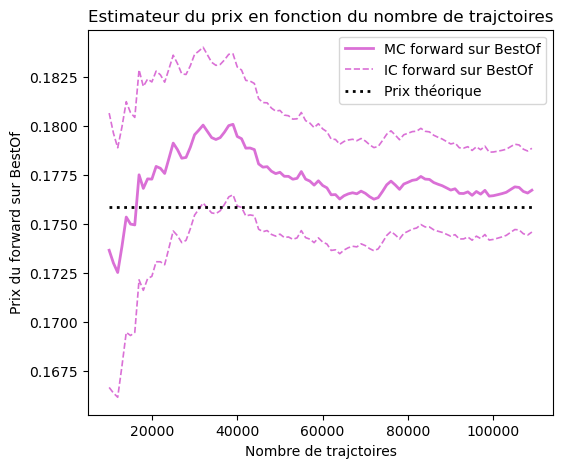

In [81]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 10000
delta_n = 1000
nb = 100
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs = np.zeros((nb,4))

###########################################################
#           Variables aléatoires et remplissage           #
###########################################################

P = BestOf_MC(fin-1)

for j in range(nb):
    erreurs[j] = intervalle_confiance_90(P[0:x0[j+1]])
    
BOth = BestOf_th()

###########################################################
#                Graphique des estimateurs                #
###########################################################

plt.figure(figsize = (6, 5))
plt.title('Estimateur du prix en fonction du nombre de trajctoires')
# MC forward sur BestOf
plt.plot(x, erreurs[:,0], color = 'orchid', linewidth = 2, label = 'MC forward sur BestOf')
plt.plot(x, erreurs[:,1], color = 'orchid', linewidth = 1.2, linestyle = '--', label = 'IC forward sur BestOf')
plt.plot(x, erreurs[:,2], color = 'orchid', linewidth = 1.2, linestyle = '--')
# Prix théorique
plt.plot(x, BOth*np.ones(np.size(x)), color = 'black', 
         linewidth = 2, linestyle = ':', label = 'Prix théorique')
# Légende
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Prix du forward sur BestOf')
plt.legend()
plt.show()

Les résultats de la méthode de Monte Carlo convergent vers le prix théorique, et l'intervalle de confiance de l'estimation contient le prix théorique avec un niveau de confiance de $90%$. Nous pouvons donc conclure que notre formule est validée avec une bonne précision.

# $\mathcal{Question~15}$

Terminons notre étude de l'option sur spread en utilisant une méthode de réduction de variance par variables de contrôle. Nous utiliserons l'option d'échange que nous avons précédemment étudiée comme variable de contrôle.

In [82]:
def echange_spread(N, S = np.array([[],[]]), vec = False):
    if np.size(S) == 0:
        S = cours_actifs(T, N)
    MC = np.exp(-r*T)*(np.maximum(alpha*S[0,:] - beta*S[1,:] - K, 0) - np.maximum(alpha*S[0,:] - beta*S[1,:], 0))
    hatsigma2 = sigma1**2 + sigma2**2 - 2*sigma1*sigma2*rho
    d1 = (np.log((alpha*S10)/(beta*S20)) + 0.5*hatsigma2*T) / np.sqrt(hatsigma2*T)
    d2 = d1 - np.sqrt(hatsigma2*T)
    echange = alpha*S10*psi(d1) - beta*S20*psi(d2)
    payoff = MC + echange
    if vec:
        return payoff
    return np.mean(payoff)

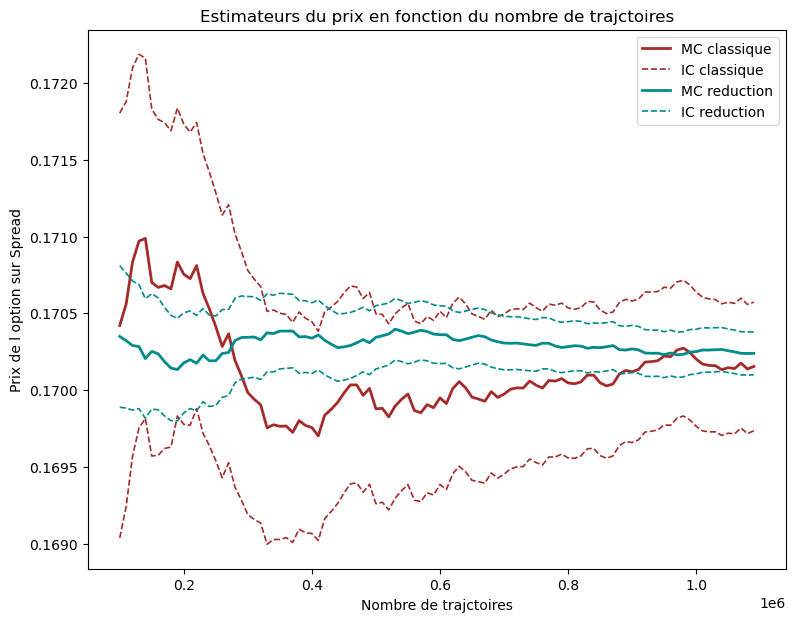

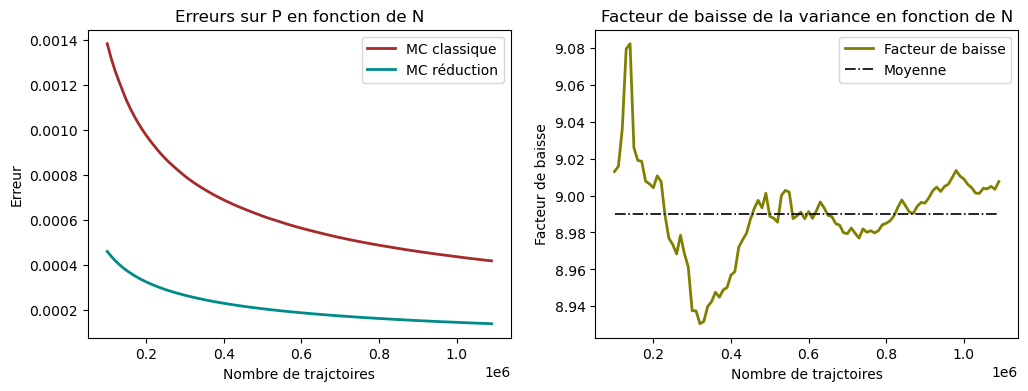

Facteur de baisse :  8.989983681669532


In [83]:
###########################################################
#  Initialisation des paramètres et tableaux de stockage  #
###########################################################

debut = 100000
delta_n = 10000
nb = 100
fin = debut + (nb-1)*delta_n + 1
x = np.arange(debut, fin, delta_n)
x0 = np.concatenate(([0], x))
erreurs1 = np.zeros((nb,4))
erreurs2 = np.zeros((nb,4))

###########################################################
#           Variables aléatoires et remplissage           #
###########################################################

S = cours_actifs(T, fin-1)
P1 = np.exp(-r*T)*np.maximum(alpha*S[0,:] - beta*S[1,:] - K, 0)
P2 = echange_spread(fin-1, S, True)

for j in range(nb):
    erreurs1[j] = intervalle_confiance_90(P1[0:x0[j+1]])
    erreurs2[j] = intervalle_confiance_90(P2[0:x0[j+1]])

###########################################################
#                Graphique des estimateurs                #
###########################################################

plt.figure(figsize = (9, 7))
plt.title('Estimateurs du prix en fonction du nombre de trajctoires')
# MC classique
plt.plot(x, erreurs1[:,0], color = 'brown', linewidth = 2, label = 'MC classique')
plt.plot(x, erreurs1[:,1], color = 'brown', linewidth = 1.2, linestyle = '--', label = 'IC classique')
plt.plot(x, erreurs1[:,2], color = 'brown', linewidth = 1.2, linestyle = '--')
# MC reduction
plt.plot(x, erreurs2[:,0], color = 'darkcyan', linewidth = 2, label = 'MC reduction')
plt.plot(x, erreurs2[:,1], color = 'darkcyan', linewidth = 1.2, linestyle = '--', label = 'IC reduction')
plt.plot(x, erreurs2[:,2], color = 'darkcyan', linewidth = 1.2, linestyle = '--')
# Légende
plt.xlabel('Nombre de trajctoires')
plt.ylabel('Prix de l option sur Spread')
plt.legend()
plt.show()

###########################################################
#                  Graphique des erreurs                  #
###########################################################

fig = plt.figure(figsize = (12, 4))
grid = plt.GridSpec(2, 2)

ax1 = fig.add_subplot(grid[:, 0])
ax1.set_title('Erreurs sur P en fonction de N')
# MC classique
ax1.plot(x, erreurs1[:,3], color = 'brown', linewidth = 2, label = 'MC classique')
# MC réduction
ax1.plot(x, erreurs2[:,3], color = 'darkcyan', linewidth = 2, label = 'MC réduction')
# Légende
ax1.set_xlabel('Nombre de trajctoires')
ax1.set_ylabel('Erreur')
ax1.legend()

ax2 = fig.add_subplot(grid[:, 1])
ax2.set_title('Facteur de baisse de la variance en fonction de N')
Baisse = (erreurs1[:,3]/erreurs2[:,3])**2
ecart = np.mean(Baisse)
ax2.plot(x, Baisse, color = 'olive', linewidth = 2, label = 'Facteur de baisse')
ax2.plot(x, np.ones(nb)*np.mean(Baisse), color = 'k', linewidth = 1.2, linestyle = '-.', label = 'Moyenne')
ax2.set_xlabel('Nombre de trajctoires')
ax2.set_ylabel('Facteur de baisse')
ax2.legend()

plt.show()

# Réduction de la variance ? 
print('Facteur de baisse : ', ecart)

Avec ces constantes initiales bien choisies, notre étude montre que l'option d'échange est la meilleure variable de contrôle pour réduire la variance de l'estimation du prix de l'option sur spread. En effet, l'utilisation de cette variable permet de réduire la variance d'un facteur de 9, soit une amélioration significative par rapport aux précédentes méthodes de réduction de variance qui n'ont pas permis de dépasser un facteur de 3.

Cette conclusion s'appuie sur des constantes initiales optimales pour notre étude, et peut varier selon les spécifications du marché et les choix des paramètres. Néanmoins, cette méthode de réduction de variance par variables de contrôle est une technique généralement utilisée en finance pour améliorer la précision des estimations de prix.